# XGBoost Training for PK-PD Elimination Equation

This notebook trains XGBoost models using **only** the PK-PD elimination equation coefficients to predict:
- **Arrhythmia** (binary: true/false)
- **Heart Damage** (binary: true/false)  
- **Concern** (multiclass: most/less/no)

Each step is shown in separate cells so you can validate the data as we go.


## Installation Instructions

**If you get import errors, run the cell below to install all required packages.**

Alternatively, you can install from the command line:
```bash
pip install pandas numpy scikit-learn xgboost joblib openpyxl matplotlib ipykernel jupyter
```


In [2]:
# Install required packages (run this cell first if you get import errors)
# Uncomment the line below and run this cell to install all dependencies

# !pip install pandas numpy scikit-learn xgboost joblib openpyxl matplotlib ipykernel

# Or install all at once:
# !pip install pandas numpy scikit-learn xgboost joblib openpyxl matplotlib ipykernel jupyter

print("If you see import errors, uncomment the pip install line above and run this cell.")
print("Required packages:")
print("  - pandas (for data manipulation)")
print("  - numpy (for numerical operations)")
print("  - scikit-learn (for machine learning)")
print("  - xgboost (for XGBoost models)")
print("  - joblib (for saving models)")
print("  - openpyxl (for reading Excel files)")
print("  - matplotlib (for plotting, optional)")
print("  - ipykernel (for Jupyter notebook support)")


If you see import errors, uncomment the pip install line above and run this cell.
Required packages:
  - pandas (for data manipulation)
  - numpy (for numerical operations)
  - scikit-learn (for machine learning)
  - xgboost (for XGBoost models)
  - joblib (for saving models)
  - openpyxl (for reading Excel files)
  - matplotlib (for plotting, optional)
  - ipykernel (for Jupyter notebook support)


In [3]:
# Dependencies: None (initial setup cell)
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import seaborn as sns

# Find project root - look for EQN_Coefficients directory (current workspace structure)
current_dir = Path.cwd()

# Strategy 1: Check if we're in Prediction_Models directory
if current_dir.name == 'Prediction_Models':
    PROJECT_ROOT = current_dir.parent
# Strategy 2: Check if EQN_Coefficients exists in current directory
elif (current_dir / 'EQN_Coefficients').exists():
    PROJECT_ROOT = current_dir
# Strategy 3: Check if EQN_Coefficients exists one level up
elif (current_dir.parent / 'EQN_Coefficients').exists():
    PROJECT_ROOT = current_dir.parent
# Strategy 4: Check if we're in a subdirectory and need to go up
elif (current_dir.parent.parent / 'EQN_Coefficients').exists():
    PROJECT_ROOT = current_dir.parent.parent
else:
    # Default: assume current directory is project root
    PROJECT_ROOT = current_dir

# Add Prediction_Models to path for utils import
prediction_models_dir = PROJECT_ROOT / 'Prediction_Models'
if prediction_models_dir.exists():
    sys.path.insert(0, str(prediction_models_dir))

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not available. Install with: pip install xgboost")

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC  # For Gaussian Kernel (Heart Damage)
from sklearn.linear_model import LogisticRegression  # For Concern
from sklearn.ensemble import RandomForestClassifier  # For Random Forest

# Import utility functions
from utils import preprocess_targets, extract_features

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30)

# Define paths relative to project root
EXCEL_PATH = PROJECT_ROOT / 'EQN_Coefficients' / 'all_equations_coefficients.xlsx'
EQUATION_NAME = 'pkpd_elimination'

print("Setup complete!")
print(f"Project root: {PROJECT_ROOT}")
print(f"Current working directory: {Path.cwd()}")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"Excel path: {EXCEL_PATH}")
print(f"Excel file exists: {EXCEL_PATH.exists()}")
print(f"Equation: {EQUATION_NAME}")

# Verify Excel file exists
if not EXCEL_PATH.exists():
    print(f"\n⚠️  WARNING: Excel file not found at {EXCEL_PATH}")
    print("Please check that the file exists or update the path.")
else:
    print("✓ Excel file found!")


Setup complete!
Project root: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO
Current working directory: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Prediction_Models
XGBoost available: True
Excel path: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\EQN_Coefficients\all_equations_coefficients.xlsx
Excel file exists: True
Equation: pkpd_elimination
✓ Excel file found!


## Step 1: Load Raw PK-PD Elimination Data

Load the PK-PD elimination equation sheet from the Excel file. This contains coefficient data for both Contractility and O2 responses.


In [4]:
# Cell 2: Load Raw PK-PD Elimination Data
print("="*80)
print("LOADING RAW PK-PD ELIMINATION DATA")
print("="*80)

# Read Excel sheet - skip first row (header with Contractility/O2 labels)
# Column names are in row 1 (0-indexed)
df_raw = pd.read_excel(EXCEL_PATH, sheet_name=EQUATION_NAME, header=1)

# Clean column names (remove whitespace)
df_raw.columns = df_raw.columns.str.strip()

# Remove rows where Drug is missing or empty
initial_rows = len(df_raw)
df_raw = df_raw[df_raw['Drug'].notna() & (df_raw['Drug'].astype(str).str.strip() != '')]

print(f"\nLoaded data from: {EXCEL_PATH}")
print(f"Sheet name: {EQUATION_NAME}")
print(f"Initial rows: {initial_rows}")
print(f"Rows after filtering: {len(df_raw)}")
print(f"Columns: {len(df_raw.columns)}")
print(f"\nColumn names:")
print(df_raw.columns.tolist())


LOADING RAW PK-PD ELIMINATION DATA

Loaded data from: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\EQN_Coefficients\all_equations_coefficients.xlsx
Sheet name: pkpd_elimination
Initial rows: 25
Rows after filtering: 25
Columns: 24

Column names:
['Drug', 'Arrhythmia', 'heart_damage', 'Concern', 'R0', 'Emax', 'kappa', 'n', 'm', 'tau', 'k_elim', 'Cmax_used', 'R2', 'N_points', 'R0.1', 'Emax.1', 'kappa.1', 'n.1', 'm.1', 'tau.1', 'k_elim.1', 'Cmax_used.1', 'R2.1', 'N_points.1']

Loaded data from: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\EQN_Coefficients\all_equations_coefficients.xlsx
Sheet name: pkpd_elimination
Initial rows: 25
Rows after filtering: 25
Columns: 24

Column names:
['Drug', 'Arrhythmia', 'heart_damage', 'Concern', 'R0', 'Emax', 'kappa', 'n', 'm', 'tau', 'k_elim', 'Cmax_used', 'R2', 'N_points', 'R0.1', 'Emax.1', 'kappa.1', 'n.1', 'm.1', 'tau.1', 'k_elim.1', 'Cmax_used.1', 'R2.1', 'N_points.1']


## Step 2: Display Raw Data Table

Inspect the raw data to see what we're working with.


In [5]:
# Cell 3: Display Raw Data Table
print("="*80)
print("RAW DATA OVERVIEW")
print("="*80)

print(f"\nData shape: {df_raw.shape}")
print(f"\nFirst few rows:")
display(df_raw.head(10))

print(f"\nData types:")
print(df_raw.dtypes)

print(f"\nMissing values per column:")
missing_counts = df_raw.isna().sum()
print(missing_counts[missing_counts > 0])

print(f"\nBasic statistics:")
display(df_raw.describe())


RAW DATA OVERVIEW

Data shape: (25, 24)

First few rows:


,Drug,Arrhythmia,heart_damage,Concern,R0,Emax,kappa,n,m,tau,k_elim,Cmax_used,R2,N_points,R0.1,Emax.1,kappa.1,n.1,m.1,tau.1,k_elim.1,Cmax_used.1,R2.1,N_points.1
0,Bortezomib,True,True,most,0.082926,0.053588,7.681700,0.330227,0.100000,16.015613,0.249199,0.290,2.992896e-01,296,13.044326,16.108710,24.472186,0.707981,5.827444,46.176610,0.000001,0.290,0.296490,296
1,Doxorubicin,True,True,most,0.106289,0.098722,0.000125,6.000000,4.786734,90.127373,0.031612,0.130,4.309061e-01,259,13.704375,100.000000,0.306375,0.535960,2.429094,52.150602,0.052220,0.130,0.811427,259
2,Epirubicin,True,True,most,0.076246,0.080421,0.001663,5.757330,0.100000,59.756941,0.009905,0.450,5.243843e-01,296,14.783848,100.000000,0.249880,0.401614,3.021163,24.938995,0.109443,0.450,0.801588,296
3,Ibrutinib,True,True,most,0.099366,0.035961,1.522754,5.700538,1.133197,84.968911,0.005986,0.530,2.025447e-01,296,25.000000,28.016141,0.076150,2.868853,6.000000,51.040449,0.027621,0.530,0.421621,296
4,Isoproterenol,True,True,most,0.088801,0.003245,1.329073,0.415815,1.078780,0.306743,0.087455,0.013,2.414760e-04,238,13.322554,9.587341,0.900598,0.100000,6.000000,31.388742,0.000001,0.013,0.124026,238
5,Panobinostat,True,True,most,0.069068,0.069110,100.000000,5.986188,0.987595,0.100000,0.010481,0.063,6.788572e-01,259,14.987791,99.998798,2.035688,0.100000,4.853697,55.487323,0.520801,0.063,0.300093,259
6,Sotalol,True,True,most,0.090965,0.018437,17.159032,0.100000,0.100017,14.220008,1.000000,3.200,5.669248e-02,272,24.456959,25.705556,0.427607,0.901097,1.795192,31.719969,0.028389,3.200,0.434377,272
7,Sunitinib,True,True,most,0.067023,0.009095,0.423390,2.005052,5.058936,65.515997,0.586478,0.150,-1.516606e-09,296,17.166636,100.000000,0.267676,0.513187,3.773792,39.658687,0.080845,0.150,0.537044,296
8,Vandetanib,True,True,most,0.113841,0.022619,2.328265,0.236979,2.904996,3.773830,1.000000,1.200,4.350557e-02,296,9.691644,100.000000,0.772940,0.238600,2.402877,30.335929,0.157477,1.200,0.512556,296
9,Cobimetinib,False,True,most,0.058870,0.024533,43.515227,1.792177,1.476978,7.018207,0.056910,0.530,1.099348e-01,296,13.290911,100.000000,0.334778,0.401940,2.089561,25.785234,0.077364,0.530,0.681042,296



Data types:
Drug             object
Arrhythmia         bool
heart_damage       bool
Concern          object
R0              float64
Emax            float64
kappa           float64
n               float64
m               float64
tau             float64
k_elim          float64
Cmax_used       float64
R2              float64
N_points          int64
R0.1            float64
Emax.1          float64
kappa.1         float64
n.1             float64
m.1             float64
tau.1           float64
k_elim.1        float64
Cmax_used.1     float64
R2.1            float64
N_points.1        int64
dtype: object

Missing values per column:
Series([], dtype: int64)

Basic statistics:


,R0,Emax,kappa,n,m,tau,k_elim,Cmax_used,R2,N_points,R0.1,Emax.1,kappa.1,n.1,m.1,tau.1,k_elim.1,Cmax_used.1,R2.1,N_points.1
count,25.000000,2.500000e+01,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,2.500000e+01,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.069520,3.766393e-02,23.563954,2.699419,2.386492,36.792285,0.308410,7.603720,1.676507e-01,316.680000,17.755712,57.481313,2.875349,0.956262,3.167309,41.739410,0.113849,7.603720,0.501724,316.680000
std,0.029219,4.416994e-02,32.462162,2.381759,2.030704,35.821477,0.397957,29.929282,2.194359e-01,114.314887,4.874789,35.577630,5.902044,1.091718,1.884690,16.924244,0.189395,29.929282,0.254989,114.314887
min,0.003627,1.514111e-13,0.000115,0.100000,0.100000,0.100000,0.005986,0.013000,-6.456758e-07,238.000000,9.691644,9.587341,0.001721,0.100000,0.212382,19.021123,0.000001,0.013000,0.084586,238.000000
25%,0.063949,1.335242e-02,0.320375,0.330227,0.535574,5.631451,0.029238,0.150000,3.573443e-02,264.000000,13.704375,27.757231,0.306375,0.329038,1.769339,25.785234,0.018793,0.150000,0.296490,264.000000
50%,0.069684,2.261898e-02,2.328265,1.792177,2.243876,16.015613,0.056910,0.530000,8.733308e-02,272.000000,17.166636,45.843748,0.772940,0.513187,2.612643,42.819224,0.052220,0.530000,0.512556,272.000000
75%,0.088794,4.590430e-02,43.515227,5.700538,3.284883,66.407708,0.586478,1.500000,2.025447e-01,296.000000,22.163366,100.000000,2.035688,0.901097,4.891413,53.479721,0.129580,1.500000,0.741512,296.000000
max,0.113841,1.997022e-01,100.000000,6.000000,6.000000,95.920713,1.000000,150.000000,8.009291e-01,648.000000,25.000000,100.000000,24.472186,3.872955,6.000000,84.718573,0.862310,150.000000,0.938894,648.000000


## Step 3: Extract Features (Contractility and O2 Coefficients)

Extract the coefficient features from the data. This will separate Contractility and O2 coefficients and create properly named features.


In [6]:
# Cell 4: Extract Features (Contractility and O2)
print("="*80)
print("EXTRACTING FEATURES")
print("="*80)

# Extract features using utility function
features_df = extract_features(df_raw, EQUATION_NAME)

print(f"\nExtracted features shape: {features_df.shape}")
print(f"Number of features: {len(features_df.columns)}")
print(f"\nFeature names:")
print(features_df.columns.tolist())

# Separate Drug and target columns from original data
targets_df = df_raw[['Drug', 'Arrhythmia', 'heart_damage', 'Concern']].copy()

# Align indices
features_df.index = df_raw.index
targets_df.index = df_raw.index

print(f"\nFeatures extracted successfully!")
print(f"Sample of first few features:")
display(features_df.head())


EXTRACTING FEATURES

Extracted features shape: (25, 14)
Number of features: 14

Feature names:
['R0_Contractility', 'Emax_Contractility', 'kappa_Contractility', 'n_Contractility', 'm_Contractility', 'tau_Contractility', 'k_elim_Contractility', 'R0_O2', 'Emax_O2', 'kappa_O2', 'n_O2', 'm_O2', 'tau_O2', 'k_elim_O2']

Features extracted successfully!
Sample of first few features:


,R0_Contractility,Emax_Contractility,kappa_Contractility,n_Contractility,m_Contractility,tau_Contractility,k_elim_Contractility,R0_O2,Emax_O2,kappa_O2,n_O2,m_O2,tau_O2,k_elim_O2
0,0.082926,0.053588,7.681700,0.330227,0.100000,16.015613,0.249199,13.044326,16.108710,24.472186,0.707981,5.827444,46.176610,0.000001
1,0.106289,0.098722,0.000125,6.000000,4.786734,90.127373,0.031612,13.704375,100.000000,0.306375,0.535960,2.429094,52.150602,0.052220
2,0.076246,0.080421,0.001663,5.757330,0.100000,59.756941,0.009905,14.783848,100.000000,0.249880,0.401614,3.021163,24.938995,0.109443
3,0.099366,0.035961,1.522754,5.700538,1.133197,84.968911,0.005986,25.000000,28.016141,0.076150,2.868853,6.000000,51.040449,0.027621
4,0.088801,0.003245,1.329073,0.415815,1.078780,0.306743,0.087455,13.322554,9.587341,0.900598,0.100000,6.000000,31.388742,0.000001


## Step 4: Display Extracted Features Table

View the extracted features with their statistics.


In [7]:
# Cell 5: Display Extracted Features Table
print("="*80)
print("EXTRACTED FEATURES DETAILS")
print("="*80)

print(f"\nFull feature matrix:")
display(features_df)

print(f"\nFeature statistics:")
display(features_df.describe())

print(f"\nMissing values per feature:")
missing_features = features_df.isna().sum()
print(missing_features[missing_features > 0])
if missing_features.sum() == 0:
    print("No missing values in features!")
else:
    print(f"\nTotal missing values: {missing_features.sum()}")


EXTRACTED FEATURES DETAILS

Full feature matrix:


,R0_Contractility,Emax_Contractility,kappa_Contractility,n_Contractility,m_Contractility,tau_Contractility,k_elim_Contractility,R0_O2,Emax_O2,kappa_O2,n_O2,m_O2,tau_O2,k_elim_O2
0,0.082926,5.358820e-02,7.681700,0.330227,0.100000,16.015613,0.249199,13.044326,16.108710,24.472186,0.707981,5.827444,46.176610,0.000001
1,0.106289,9.872192e-02,0.000125,6.000000,4.786734,90.127373,0.031612,13.704375,100.000000,0.306375,0.535960,2.429094,52.150602,0.052220
2,0.076246,8.042146e-02,0.001663,5.757330,0.100000,59.756941,0.009905,14.783848,100.000000,0.249880,0.401614,3.021163,24.938995,0.109443
3,0.099366,3.596126e-02,1.522754,5.700538,1.133197,84.968911,0.005986,25.000000,28.016141,0.076150,2.868853,6.000000,51.040449,0.027621
4,0.088801,3.244984e-03,1.329073,0.415815,1.078780,0.306743,0.087455,13.322554,9.587341,0.900598,0.100000,6.000000,31.388742,0.000001
5,0.069068,6.911029e-02,100.000000,5.986188,0.987595,0.100000,0.010481,14.987791,99.998798,2.035688,0.100000,4.853697,55.487323,0.520801
6,0.090965,1.843706e-02,17.159032,0.100000,0.100017,14.220008,1.000000,24.456959,25.705556,0.427607,0.901097,1.795192,31.719969,0.028389
7,0.067023,9.095160e-03,0.423390,2.005052,5.058936,65.515997,0.586478,17.166636,100.000000,0.267676,0.513187,3.773792,39.658687,0.080845
8,0.113841,2.261898e-02,2.328265,0.236979,2.904996,3.773830,1.000000,9.691644,100.000000,0.772940,0.238600,2.402877,30.335929,0.157477
9,0.058870,2.453275e-02,43.515227,1.792177,1.476978,7.018207,0.056910,13.290911,100.000000,0.334778,0.401940,2.089561,25.785234,0.077364



Feature statistics:


,R0_Contractility,Emax_Contractility,kappa_Contractility,n_Contractility,m_Contractility,tau_Contractility,k_elim_Contractility,R0_O2,Emax_O2,kappa_O2,n_O2,m_O2,tau_O2,k_elim_O2
count,25.000000,2.500000e+01,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.069520,3.766393e-02,23.563954,2.699419,2.386492,36.792285,0.308410,17.755712,57.481313,2.875349,0.956262,3.167309,41.739410,0.113849
std,0.029219,4.416994e-02,32.462162,2.381759,2.030704,35.821477,0.397957,4.874789,35.577630,5.902044,1.091718,1.884690,16.924244,0.189395
min,0.003627,1.514111e-13,0.000115,0.100000,0.100000,0.100000,0.005986,9.691644,9.587341,0.001721,0.100000,0.212382,19.021123,0.000001
25%,0.063949,1.335242e-02,0.320375,0.330227,0.535574,5.631451,0.029238,13.704375,27.757231,0.306375,0.329038,1.769339,25.785234,0.018793
50%,0.069684,2.261898e-02,2.328265,1.792177,2.243876,16.015613,0.056910,17.166636,45.843748,0.772940,0.513187,2.612643,42.819224,0.052220
75%,0.088794,4.590430e-02,43.515227,5.700538,3.284883,66.407708,0.586478,22.163366,100.000000,2.035688,0.901097,4.891413,53.479721,0.129580
max,0.113841,1.997022e-01,100.000000,6.000000,6.000000,95.920713,1.000000,25.000000,100.000000,24.472186,3.872955,6.000000,84.718573,0.862310



Missing values per feature:
Series([], dtype: int64)
No missing values in features!


## Step 5: Preprocess Targets

Convert target columns to numeric format:
- Arrhythmia/Heart Damage: 'true'/'false' → 1/0
- Concern: 'most'/'less'/'no' → 2/1/0


In [8]:
# Cell 6: Preprocess Targets
print("="*80)
print("PREPROCESSING TARGETS")
print("="*80)

# Drop rows with missing target labels
initial_target_rows = len(targets_df)
targets_df = targets_df.dropna(subset=['Arrhythmia', 'heart_damage', 'Concern'])
dropped_rows = initial_target_rows - len(targets_df)

if dropped_rows > 0:
    print(f"Dropped {dropped_rows} rows with missing target labels")

# Align features with targets
features_df = features_df.loc[targets_df.index].copy()

# Convert targets to numeric
print("\nConverting targets to numeric format...")
arrhythmia = preprocess_targets(targets_df, 'Arrhythmia').values
heart_damage = preprocess_targets(targets_df, 'heart_damage').values
concern = preprocess_targets(targets_df, 'Concern').values

print(f"\nTarget distributions:")
print(f"  Arrhythmia: {np.sum(arrhythmia==1)} positive (true), {np.sum(arrhythmia==0)} negative (false)")
print(f"  Heart Damage: {np.sum(heart_damage==1)} positive (true), {np.sum(heart_damage==0)} negative (false)")
print(f"  Concern: {np.sum(concern==2)} most, {np.sum(concern==1)} less, {np.sum(concern==0)} no")

print(f"\nFinal dataset size: {len(features_df)} samples, {len(features_df.columns)} features")


PREPROCESSING TARGETS

Converting targets to numeric format...

Target distributions:
  Arrhythmia: 14 positive (true), 11 negative (false)
  Heart Damage: 20 positive (true), 5 negative (false)
  Concern: 15 most, 6 less, 4 no

Final dataset size: 25 samples, 14 features


## Step 6: Display Preprocessed Targets Table

View the targets with both original and numeric values.


In [9]:
# Cell 7: Display Preprocessed Targets Table
print("="*80)
print("PREPROCESSED TARGETS TABLE")
print("="*80)

# Create display DataFrame with original and numeric values
targets_display = targets_df.copy()
targets_display['Arrhythmia numeric'] = arrhythmia
targets_display['Heart Damage numeric'] = heart_damage
targets_display['Concern numeric'] = concern

print("\nTargets with numeric conversions:")
display(targets_display)

print("\nClass distributions:")
print("\nArrhythmia:")
print(targets_display['Arrhythmia'].value_counts())
print("\nHeart Damage:")
# Fix KeyError by using correct column name 'heart_damage'
print(targets_display['heart_damage'].value_counts())
print("\nConcern:")
print(targets_display['Concern'].value_counts())


PREPROCESSED TARGETS TABLE

Targets with numeric conversions:


,Drug,Arrhythmia,heart_damage,Concern,Arrhythmia numeric,Heart Damage numeric,Concern numeric
0,Bortezomib,True,True,most,1,1,2
1,Doxorubicin,True,True,most,1,1,2
2,Epirubicin,True,True,most,1,1,2
3,Ibrutinib,True,True,most,1,1,2
4,Isoproterenol,True,True,most,1,1,2
5,Panobinostat,True,True,most,1,1,2
6,Sotalol,True,True,most,1,1,2
7,Sunitinib,True,True,most,1,1,2
8,Vandetanib,True,True,most,1,1,2
9,Cobimetinib,False,True,most,0,1,2



Class distributions:

Arrhythmia:
Arrhythmia
True     14
False    11
Name: count, dtype: int64

Heart Damage:
heart_damage
True     20
False     5
Name: count, dtype: int64

Concern:
Concern
most    15
less     6
no       4
Name: count, dtype: int64


## Step 9: Train XGBoost for Arrhythmia

Train XGBoost model to predict Arrhythmia (binary classification) with 5-fold cross-validation (80% train, 20% test per fold).


In [10]:
# Cell 10: Train XGBoost for Arrhythmia
if not XGBOOST_AVAILABLE:
    print("ERROR: XGBoost is not installed. Install with: pip install xgboost")
else:
    print("="*80)
    print("TRAINING XGBOOST FOR ARRHYTHMIA")
    print("="*80)
    
    # Create XGBoost classifier for binary classification
    xgb_model = xgb.XGBClassifier(
        n_estimators=150,
        max_depth=4,
        learning_rate=0.08,
        subsample=0.9,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False
    )
    
    # Create pipeline with standardization
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', xgb_model)
    ])
    
    # Set up 5-fold stratified cross-validation (20% test, 80% train per fold)
    n_folds = 3
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    print(f"\nRunning {n_folds}-fold cross-validation...")
    print(f"Train/Test split per fold: {100*(n_folds-1)/n_folds:.0f}% train, {100/n_folds:.0f}% test")
    
    # Compute CV scores
    accuracy_scores = cross_val_score(pipeline, features_df, arrhythmia, cv=cv, scoring='accuracy', n_jobs=-1)
    f1_scores = cross_val_score(pipeline, features_df, arrhythmia, cv=cv, scoring='f1', n_jobs=-1)
    # AUC-ROC for binary classification
    auc_scores = cross_val_score(pipeline, features_df, arrhythmia, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    # Display fold-by-fold results
    print("\n" + "="*80)
    print("CROSS-VALIDATION RESULTS (Fold-by-Fold)")
    print("="*80)
    cv_results = pd.DataFrame({
        'Fold': range(1, n_folds + 1),
        'Accuracy': accuracy_scores,
        'F1-Score': f1_scores,
        'AUC-ROC': auc_scores
    })
    display(cv_results)
    
    print(f"\nMean Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
    print(f"Mean F1-Score: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
    print(f"Mean AUC-ROC: {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")
    
    # Train final model on all data
    print("\nTraining final model on all data...")
    pipeline.fit(features_df, arrhythmia)
    
    # Get feature importances
    feature_importances = pipeline.named_steps['xgb'].feature_importances_
    importance_df_arrhythmia = pd.DataFrame({
        'Feature': features_df.columns,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Most Important Features for Arrhythmia:")
    display(importance_df_arrhythmia.head(10))
    
    # Store model and results
    model_arrhythmia = pipeline
    results_arrhythmia = {
        'accuracy_mean': accuracy_scores.mean(),
        'accuracy_std': accuracy_scores.std(),
        'f1_mean': f1_scores.mean(),
        'f1_std': f1_scores.std(),
        'auc_mean': auc_scores.mean(),
        'auc_std': auc_scores.std(),
        'cv_accuracy_scores': accuracy_scores,
        'cv_f1_scores': f1_scores,
        'cv_auc_scores': auc_scores,
        'feature_importances': importance_df_arrhythmia
    }
    
    # Make Arrhythmia feature importances accessible by a standard name for later plotting
    arrhythmia_importances = results_arrhythmia['feature_importances']
    
    print("\n✓ Arrhythmia model training complete!")


TRAINING XGBOOST FOR ARRHYTHMIA

Running 3-fold cross-validation...
Train/Test split per fold: 67% train, 33% test

CROSS-VALIDATION RESULTS (Fold-by-Fold)

CROSS-VALIDATION RESULTS (Fold-by-Fold)


,Fold,Accuracy,F1-Score,AUC-ROC
0,1,0.777778,0.800000,0.800
1,2,0.750000,0.750000,0.800
2,3,0.875000,0.888889,0.875



Mean Accuracy: 0.8009 ± 0.0536
Mean F1-Score: 0.8130 ± 0.0574
Mean AUC-ROC: 0.8250 ± 0.0354

Training final model on all data...

Top 10 Most Important Features for Arrhythmia:

Top 10 Most Important Features for Arrhythmia:


c:\Users\NoahB\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:27:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Feature,Importance
0,R0_Contractility,0.269799
6,k_elim_Contractility,0.104979
5,tau_Contractility,0.103587
4,m_Contractility,0.099338
7,R0_O2,0.094837
10,n_O2,0.074466
2,kappa_Contractility,0.050019
9,kappa_O2,0.047848
8,Emax_O2,0.046190
11,m_O2,0.041327



✓ Arrhythmia model training complete!


## Understanding Cross-Validation and Train/Test Split

**Important:** XGBoost uses **K-Fold Cross-Validation**, not a traditional train/test split.

### How K-Fold Cross-Validation Works:

- **K-Fold CV** (5-fold): The data is divided into K equal parts (folds)
- **Each fold serves as test set once**: For each of the K iterations:
  - **Training set**: K-1 folds (80% of data for 5-fold)
  - **Test set**: 1 fold (20% of data for 5-fold)
- **All data is used**: Every sample appears in the test set exactly once
- **Final model**: After CV, a final model is trained on **100% of the data**

### Example with 5-Fold CV (27 samples):
- **Fold 1**: Train on samples 1-22, Test on samples 23-27 (~5-6 samples)
- **Fold 2**: Train on samples 1-17, 23-27, Test on samples 18-22 (~5-6 samples)
- ... (continues for all 5 folds)
- **Final**: Train on all 27 samples

### Metrics Reported:
- **Accuracy**: % of correct predictions
- **F1-Score**: Harmonic mean of precision and recall
- **AUC-ROC**: Area under ROC curve (binary classification only)


## Step 10: Train XGBoost for Heart Damage (Heart Damage)

Train XGBoost model to predict Heart Damage (Heart Damage) with 5-fold cross-validation (80% train, 20% test per fold).


In [11]:
   # Cell 11: Train Gaussian Kernel (RBF SVM) for Heart Damage
   # Depends on: Cell 9 (Extracted features), Cell 13 (Preprocessed targets)
   print("="*80)
   print("TRAINING GAUSSIAN KERNEL (RBF SVM) FOR Heart Damage")
   print("="*80)

   svm_model = SVC(
       kernel='rbf',
       C=1.0,
       gamma='scale',
       probability=True,  # Needed for ROC curves
       random_state=40
   )

   pipeline = Pipeline([
       ('scaler', StandardScaler()),
       ('svm', svm_model)
   ])

   n_folds = 3
   random_int = random.randint(1, 1000)
   cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=21)
   print(f"Random state: {random_int}")
   print(f"\nRunning {n_folds}-fold cross-validation...")
   print(f"Train/Test split per fold: {100*(n_folds-1)/n_folds:.0f}% train, {100/n_folds:.0f}% test")

   accuracy_scores = cross_val_score(pipeline, features_df, heart_damage, cv=cv, scoring='accuracy', n_jobs=-1)
   f1_scores = cross_val_score(pipeline, features_df, heart_damage, cv=cv, scoring='f1', n_jobs=-1)
   auc_scores = cross_val_score(pipeline, features_df, heart_damage, cv=cv, scoring='roc_auc', n_jobs=-1)

   print("\n" + "="*80)
   print("CROSS-VALIDATION RESULTS (Fold-by-Fold)")
   print("="*80)
   cv_results = pd.DataFrame({
       'Fold': range(1, n_folds + 1),
       'Accuracy': accuracy_scores,
       'F1-Score': f1_scores,
       'AUC-ROC': auc_scores
   })
   display(cv_results)

   print(f"\nMean Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
   print(f"Mean F1-Score: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
   print(f"Mean AUC-ROC: {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")

   print("\nTraining final model on all data...")
   pipeline.fit(features_df, heart_damage)

   print("\nNote: Gaussian Kernel (RBF SVM) does not provide feature importances like tree-based models.")
   print("The RBF kernel transforms features non-linearly, making individual feature contributions less interpretable.")

   model_heart_damage = pipeline
   results_heart_damage = {
       'accuracy_mean': accuracy_scores.mean(),
       'accuracy_std': accuracy_scores.std(),
       'f1_mean': f1_scores.mean(),
       'f1_std': f1_scores.std(),
       'auc_mean': auc_scores.mean(),
       'auc_std': auc_scores.std(),
       'cv_accuracy_scores': accuracy_scores,
       'cv_f1_scores': f1_scores,
       'cv_auc_scores': auc_scores,
       'feature_importances': None}

   # If you run permutation importance later, save it as heart_damage_importances for downstream use:
   # heart_damage_importances = <permutation importance DataFrame or object>

TRAINING GAUSSIAN KERNEL (RBF SVM) FOR Heart Damage
Random state: 804

Running 3-fold cross-validation...
Train/Test split per fold: 67% train, 33% test

CROSS-VALIDATION RESULTS (Fold-by-Fold)

CROSS-VALIDATION RESULTS (Fold-by-Fold)


,Fold,Accuracy,F1-Score,AUC-ROC
0,1,0.777778,0.875000,1.000000
1,2,0.875000,0.933333,0.714286
2,3,0.750000,0.857143,0.916667



Mean Accuracy: 0.8009 ± 0.0536
Mean F1-Score: 0.8885 ± 0.0325
Mean AUC-ROC: 0.8770 ± 0.1200

Training final model on all data...

Note: Gaussian Kernel (RBF SVM) does not provide feature importances like tree-based models.
The RBF kernel transforms features non-linearly, making individual feature contributions less interpretable.


## Step 11: Train Logistic Regression for Concern (Best Model)

Train Logistic Regression model to predict Concern (multiclass classification: most/less/no) with 5-fold cross-validation (80% train, 20% test per fold).
Using random_state=155 (best performing configuration from automated search).


In [12]:
# Cell 12: Train Random Forest for Concern (random_state=122)
# This configuration performed well in screen tests
print("="*80)
print("TRAINING RANDOM FOREST FOR CONCERN (MULTICLASS)")
print("="*80)
print("Using random_state=122 (best performing configuration from screen test)")
print("="*80)

# Create Random Forest classifier for multiclass classification
rf_model = RandomForestClassifier(
    n_estimators=101,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Create pipeline with standardization
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', rf_model)
])

# Set up 3-fold stratified cross-validation (33% test, 67% train per fold)
# Using 3 folds instead of 5 to ensure all classes are represented in each fold
# (With only 4 samples in "no" class, 5-fold CV can cause missing classes in some folds)
n_folds = 3
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=122)
print(f"CV random_state: 122")
print(f"\nRunning {n_folds}-fold cross-validation...")
print(f"Train/Test split per fold: {100*(n_folds-1)/n_folds:.0f}% train, {100/n_folds:.0f}% test")
print("Note: Using 3 folds to ensure all classes are represented in each fold")

# Compute CV scores (use macro F1 for multiclass)
accuracy_scores = cross_val_score(pipeline, features_df, concern, cv=cv, scoring='accuracy', n_jobs=-1)
f1_scores = cross_val_score(pipeline, features_df, concern, cv=cv, scoring='f1_macro', n_jobs=-1)
# AUC-ROC for multiclass (one-vs-rest)
# Handle potential NaN values if a class is missing in a fold
try:
    auc_scores = cross_val_score(pipeline, features_df, concern, cv=cv, scoring='roc_auc_ovr', n_jobs=-1)
    # Filter out NaN values if any occur
    auc_scores_valid = auc_scores[~np.isnan(auc_scores)]
    if len(auc_scores_valid) < len(auc_scores):
        print(f"Warning: {len(auc_scores) - len(auc_scores_valid)} fold(s) produced NaN AUC-ROC (likely due to missing class in fold)")
except Exception as e:
    print(f"Warning: Could not compute AUC-ROC: {e}")
    auc_scores = np.array([np.nan] * n_folds)
    auc_scores_valid = np.array([])

# Display fold-by-fold results
print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS (Fold-by-Fold)")
print("="*80)
cv_results = pd.DataFrame({
    'Fold': range(1, n_folds + 1),
    'Accuracy': accuracy_scores,
    'F1-Score (Macro)': f1_scores,
    'AUC-ROC (OVR)': auc_scores
})
display(cv_results)

print(f"\nMean Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
print(f"Mean F1-Score (Macro): {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
# Handle NaN values in AUC-ROC
if len(auc_scores_valid) > 0:
    print(f"Mean AUC-ROC (One-vs-Rest): {auc_scores_valid.mean():.4f} ± {auc_scores_valid.std():.4f} ⭐")
    print(f"  (Computed from {len(auc_scores_valid)}/{len(auc_scores)} folds with valid AUC-ROC)")
else:
    print(f"Mean AUC-ROC (One-vs-Rest): NaN (could not compute - likely due to class imbalance in folds)")
    print(f"  Consider using fewer folds or a different evaluation metric")

# Train final model on all data
print("\nTraining final model on all data...")
pipeline.fit(features_df, concern)

# Get feature importances (Random Forest provides feature importances)
rf_model_fitted = pipeline.named_steps['rf']
feature_importances = rf_model_fitted.feature_importances_
importance_df_concern_rf = pd.DataFrame({
    'Feature': features_df.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features for Concern (Random Forest):")
display(importance_df_concern_rf.head(10))

# Store model and results
model_concern_rf = pipeline
results_concern_rf = {
    'accuracy_mean': accuracy_scores.mean(),
    'accuracy_std': accuracy_scores.std(),
    'f1_mean': f1_scores.mean(),
    'f1_std': f1_scores.std(),
    'auc_mean': auc_scores_valid.mean() if len(auc_scores_valid) > 0 else np.nan,
    'auc_std': auc_scores_valid.std() if len(auc_scores_valid) > 0 else np.nan,
    'cv_accuracy_scores': accuracy_scores,
    'cv_f1_scores': f1_scores,
    'cv_auc_scores': auc_scores,
    'feature_importances': importance_df_concern_rf,
    'random_state': 122
}

# Save the feature importances DataFrame for the concern model
concern_importances = results_concern_rf['feature_importances']

print("\n✓ Concern (Random Forest) model training complete!")


TRAINING RANDOM FOREST FOR CONCERN (MULTICLASS)
Using random_state=122 (best performing configuration from screen test)
CV random_state: 122

Running 3-fold cross-validation...
Train/Test split per fold: 67% train, 33% test
Note: Using 3 folds to ensure all classes are represented in each fold

CROSS-VALIDATION RESULTS (Fold-by-Fold)

CROSS-VALIDATION RESULTS (Fold-by-Fold)


,Fold,Accuracy,F1-Score (Macro),AUC-ROC (OVR)
0,1,0.666667,0.478632,0.759524
1,2,0.750000,0.533333,0.838095
2,3,0.750000,0.611111,0.833333



Mean Accuracy: 0.7222 ± 0.0393
Mean F1-Score (Macro): 0.5410 ± 0.0544
Mean AUC-ROC (One-vs-Rest): 0.8103 ± 0.0360 ⭐
  (Computed from 3/3 folds with valid AUC-ROC)

Training final model on all data...

Top 10 Most Important Features for Concern (Random Forest):

Top 10 Most Important Features for Concern (Random Forest):


,Feature,Importance
10,n_O2,0.141106
0,R0_Contractility,0.108791
12,tau_O2,0.086828
9,kappa_O2,0.084372
1,Emax_Contractility,0.083495
5,tau_Contractility,0.081914
13,k_elim_O2,0.078191
6,k_elim_Contractility,0.077782
4,m_Contractility,0.064236
2,kappa_Contractility,0.052821



✓ Concern (Random Forest) model training complete!


## Step 12: Compare Model Performance

Compare the performance of all three models side-by-side.


MODEL PERFORMANCE COMPARISON
Models used:
  - Arrhythmia: XGBoost
  - Heart Damage: Gaussian Kernel (RBF SVM)
  - Concern: Random Forest (random_state=122)

Performance Summary:


,Target,Accuracy,F1-Score,AUC-ROC,Number of Features
0,Arrhythmia,0.8009 ± 0.0536,0.8130 ± 0.0574,0.8250 ± 0.0354,14
1,Heart Damage,0.8009 ± 0.0536,0.8885 ± 0.0325,0.8770 ± 0.1200,14
2,Concern,0.7222 ± 0.0393,0.5410 ± 0.0544,0.8103 ± 0.0360,14



Detailed Metrics:


,Target,Mean CV Accuracy,Std CV Accuracy,Mean CV F1-Score,Std CV F1-Score,Mean CV AUC-ROC,Std CV AUC-ROC,Number of Features
0,Arrhythmia,0.800926,0.053592,0.812963,0.057437,0.825000,0.035355,14
1,Heart Damage,0.800926,0.053592,0.888492,0.032535,0.876984,0.119970,14
2,Concern,0.722222,0.039284,0.541026,0.054357,0.810317,0.035969,14



PERFORMANCE BAR PLOTS WITH STANDARD DEVIATION


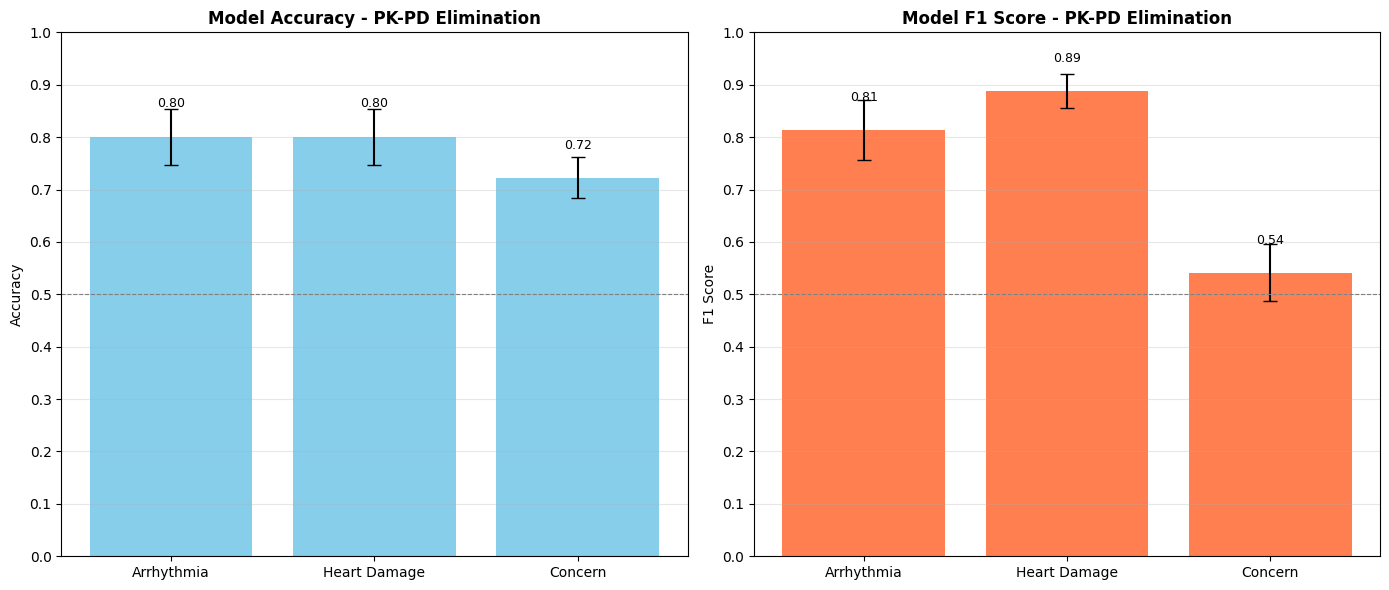


ROC CURVE PLOTS

1. Computing ROC curve for Arrhythmia (XGBoost)...


c:\Users\NoahB\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:27:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\NoahB\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:27:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\NoahB\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:27:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\NoahB\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:27:49] WARNING: C:\actio

2. Computing ROC curve for Heart Damage (Gaussian Kernel)...
   Using same CV parameters as training: n_folds=3, random_state=21
3. Computing ROC curves for Concern (Random Forest - One-vs-Rest)...


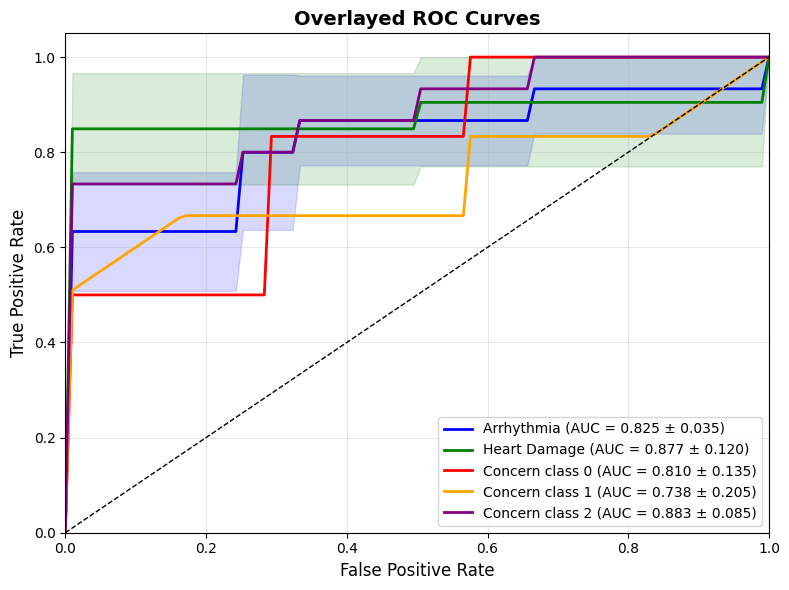


✓ ROC curves generated successfully!


In [13]:
# Cell 13: Compare Model Performance with ROC Curves
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print("Models used:")
print("  - Arrhythmia: XGBoost")
print("  - Heart Damage: Gaussian Kernel (RBF SVM)")
print("  - Concern: Random Forest (random_state=122)")
print("="*80)

# Create comparison table
comparison_data = {
    'Target': ['Arrhythmia', 'Heart Damage', 'Concern'],
    'Mean CV Accuracy': [
        results_arrhythmia['accuracy_mean'],
        results_heart_damage['accuracy_mean'],
        results_concern_rf['accuracy_mean']
    ],
    'Std CV Accuracy': [
        results_arrhythmia['accuracy_std'],
        results_heart_damage['accuracy_std'],
        results_concern_rf['accuracy_std']
    ],
    'Mean CV F1-Score': [
        results_arrhythmia['f1_mean'],
        results_heart_damage['f1_mean'],
        results_concern_rf['f1_mean']
    ],
    'Std CV F1-Score': [
        results_arrhythmia['f1_std'],
        results_heart_damage['f1_std'],
        results_concern_rf['f1_std']
    ],
    'Mean CV AUC-ROC': [
        results_arrhythmia['auc_mean'],
        results_heart_damage['auc_mean'],
        results_concern_rf['auc_mean'] if not np.isnan(results_concern_rf['auc_mean']) else None
    ],
    'Std CV AUC-ROC': [
        results_arrhythmia['auc_std'],
        results_heart_damage['auc_std'],
        results_concern_rf['auc_std'] if not np.isnan(results_concern_rf['auc_std']) else None
    ],
    'Number of Features': [len(features_df.columns)] * 3
}

comparison_df = pd.DataFrame(comparison_data)

# Format for display
comparison_df['Accuracy'] = comparison_df.apply(
    lambda x: f"{x['Mean CV Accuracy']:.4f} ± {x['Std CV Accuracy']:.4f}", axis=1
)
comparison_df['F1-Score'] = comparison_df.apply(
    lambda x: f"{x['Mean CV F1-Score']:.4f} ± {x['Std CV F1-Score']:.4f}", axis=1
)
comparison_df['AUC-ROC'] = comparison_df.apply(
    lambda x: f"{x['Mean CV AUC-ROC']:.4f} ± {x['Std CV AUC-ROC']:.4f}" if x['Mean CV AUC-ROC'] is not None and not np.isnan(x['Mean CV AUC-ROC']) else "N/A", axis=1
)

display_df = comparison_df[['Target', 'Accuracy', 'F1-Score', 'AUC-ROC', 'Number of Features']]

print("\nPerformance Summary:")
display(display_df)

print("\nDetailed Metrics:")
display(comparison_df[['Target', 'Mean CV Accuracy', 'Std CV Accuracy', 
                       'Mean CV F1-Score', 'Std CV F1-Score',
                       'Mean CV AUC-ROC', 'Std CV AUC-ROC', 'Number of Features']])

# ============================================================================
# ============================================================================
# PERFORMANCE BAR PLOTS WITH STANDARD DEVIATION
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE BAR PLOTS WITH STANDARD DEVIATION")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Accuracy with Standard Deviation
axes[0].bar(comparison_df['Target'], comparison_df['Mean CV Accuracy'],
           yerr=comparison_df['Std CV Accuracy'], capsize=5, color='skyblue')
axes[0].set_title('Model Accuracy - PK-PD Elimination', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=10)
axes[0].set_ylim(0, 1.0)
axes[0].set_yticks(np.arange(0, 1.1, 0.1))
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(0.5, color='gray', linestyle='--', linewidth=0.8) # Reference line
for i, val in enumerate(comparison_df['Mean CV Accuracy']):
    axes[0].text(i, val + 0.05, f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# Plot 2: F1 Score with Standard Deviation
axes[1].bar(comparison_df['Target'], comparison_df['Mean CV F1-Score'],
           yerr=comparison_df['Std CV F1-Score'], capsize=5, color='coral')
axes[1].set_title('Model F1 Score - PK-PD Elimination', fontsize=12, fontweight='bold')
axes[1].set_ylabel('F1 Score', fontsize=10)
axes[1].set_ylim(0, 1.0)
axes[1].set_yticks(np.arange(0, 1.1, 0.1))
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(0.5, color='gray', linestyle='--', linewidth=0.8) # Reference line
for i, val in enumerate(comparison_df['Mean CV F1-Score']):
    axes[1].text(i, val + 0.05, f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# ROC CURVE PLOTS
# ============================================================================
print("\n" + "="*80)
print("ROC CURVE PLOTS")
print("="*80)

# Set up cross-validation for ROC curve computation
from sklearn.model_selection import StratifiedKFold

# 1. Arrhythmia (Binary Classification)
print("\n1. Computing ROC curve for Arrhythmia (XGBoost)...")
n_folds = 3
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
tprs_arrhythmia = []
aucs_arrhythmia = []
mean_fpr_arrhythmia = np.linspace(0, 1, 100)

# Import XGBoost if needed
if XGBOOST_AVAILABLE:
    import xgboost as xgb

for train_idx, test_idx in cv.split(features_df, arrhythmia):
    X_train, X_test = features_df.iloc[train_idx], features_df.iloc[test_idx]
    # Handle both pandas Series and numpy arrays
    if hasattr(arrhythmia, 'iloc'):
        y_train, y_test = arrhythmia.iloc[train_idx], arrhythmia.iloc[test_idx]
    else:
        y_train, y_test = arrhythmia[train_idx], arrhythmia[test_idx]
    
    # Create a fresh pipeline instance for this fold (matching cross_val_score behavior)
    if XGBOOST_AVAILABLE:
        xgb_fold = xgb.XGBClassifier(
            n_estimators=150,
            max_depth=4,
            learning_rate=0.08,
            subsample=0.9,
            objective='binary:logistic',
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1,
            use_label_encoder=False
        )
        pipeline_fold = Pipeline([('scaler', StandardScaler()), ('xgb', xgb_fold)])
        pipeline_fold.fit(X_train, y_train)
        y_pred_proba = pipeline_fold.predict_proba(X_test)[:, 1]
    else:
        # Fallback if XGBoost not available
        model_arrhythmia.fit(X_train, y_train)
        y_pred_proba = model_arrhythmia.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    aucs_arrhythmia.append(roc_auc)
    
    interp_tpr = np.interp(mean_fpr_arrhythmia, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_arrhythmia.append(interp_tpr)

mean_tpr_arrhythmia = np.mean(tprs_arrhythmia, axis=0)
mean_tpr_arrhythmia[-1] = 1.0
# Use mean of individual fold AUCs (matches training metric) rather than AUC of mean curve
mean_auc_arrhythmia = np.mean(aucs_arrhythmia)
std_auc_arrhythmia = np.std(aucs_arrhythmia)

# 2. Heart Damage (Binary Classification)
print("2. Computing ROC curve for Heart Damage (Gaussian Kernel)...")
print("   Using same CV parameters as training: n_folds=3, random_state=21")
tprs_heart_damage = []
aucs_heart_damage = []
mean_fpr_heart_damage = np.linspace(0, 1, 100)

# Use the same CV parameters and model configuration as the original training
cv_heart_damage = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)

for train_idx, test_idx in cv_heart_damage.split(features_df, heart_damage):
    X_train, X_test = features_df.iloc[train_idx], features_df.iloc[test_idx]
    # Handle both pandas Series and numpy arrays
    if hasattr(heart_damage, 'iloc'):
        y_train, y_test = heart_damage.iloc[train_idx], heart_damage.iloc[test_idx]
    else:
        y_train, y_test = heart_damage[train_idx], heart_damage[test_idx]
    
    # Create a fresh pipeline instance for this fold (match training config exactly)
    svm_fold = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=40)
    pipeline_fold = Pipeline([('scaler', StandardScaler()), ('svm', svm_fold)])
    pipeline_fold.fit(X_train, y_train)
    # Use decision_function scores (same metric used by roc_auc during training)
    y_scores = pipeline_fold.decision_function(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    aucs_heart_damage.append(roc_auc)
    
    interp_tpr = np.interp(mean_fpr_heart_damage, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_heart_damage.append(interp_tpr)

mean_tpr_heart_damage = np.mean(tprs_heart_damage, axis=0)
mean_tpr_heart_damage[-1] = 1.0
# Use mean of individual fold AUCs (matches training metric) rather than AUC of mean curve
mean_auc_heart_damage = np.mean(aucs_heart_damage)
std_auc_heart_damage = np.std(aucs_heart_damage)

# 3. Concern (Multiclass - One-vs-Rest)
print("3. Computing ROC curves for Concern (Random Forest - One-vs-Rest)...")
# Get unique classes
classes_concern = np.unique(concern)
n_classes = len(classes_concern)
# Binarize the labels for one-vs-rest
y_bin_concern = label_binarize(concern, classes=classes_concern)

tprs_concern = dict()
aucs_concern = dict()
mean_fpr_concern = np.linspace(0, 1, 100)

for i, class_name in enumerate(classes_concern):
    tprs_concern[i] = []
    aucs_concern[i] = []
    
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=122)
    for train_idx, test_idx in cv.split(features_df, concern):
        X_train, X_test = features_df.iloc[train_idx], features_df.iloc[test_idx]
        y_train, y_test = y_bin_concern[train_idx, i], y_bin_concern[test_idx, i]
        
        # Handle both pandas Series and numpy arrays
        if hasattr(concern, 'iloc'):
            concern_train = concern.iloc[train_idx]
        else:
            concern_train = concern[train_idx]
        
        model_concern_rf.fit(X_train, concern_train)
        y_pred_proba = model_concern_rf.predict_proba(X_test)[:, i]
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        aucs_concern[i].append(roc_auc)
        
        interp_tpr = np.interp(mean_fpr_concern, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs_concern[i].append(interp_tpr)

# Create a single combined plot (superposed ROC curves)
plt.figure(figsize=(8, 6))

# Arrhythmia curve
std_tpr = np.std(tprs_arrhythmia, axis=0)
tprs_upper = np.minimum(mean_tpr_arrhythmia + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_arrhythmia - std_tpr, 0)
plt.plot(mean_fpr_arrhythmia, mean_tpr_arrhythmia, lw=2, color='blue',
         label=f'Arrhythmia (AUC = {mean_auc_arrhythmia:.3f} ± {std_auc_arrhythmia:.3f})')
plt.fill_between(mean_fpr_arrhythmia, tprs_lower, tprs_upper, alpha=0.15, color='blue')

# Heart Damage curve
std_tpr = np.std(tprs_heart_damage, axis=0)
tprs_upper = np.minimum(mean_tpr_heart_damage + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_heart_damage - std_tpr, 0)
plt.plot(mean_fpr_heart_damage, mean_tpr_heart_damage, lw=2, color='green',
         label=f'Heart Damage (AUC = {mean_auc_heart_damage:.3f} ± {std_auc_heart_damage:.3f})')
plt.fill_between(mean_fpr_heart_damage, tprs_lower, tprs_upper, alpha=0.15, color='green')

# Concern (aggregate One-vs-Rest)
colors = ['red', 'orange', 'purple']
class_name_map = {'no': 'Concern: no', 'less': 'Concern: less', 'most': 'Concern: most'}
for i, class_val in enumerate(classes_concern):
    mean_tpr = np.mean(tprs_concern[i], axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs_concern[i])
    std_auc = np.std(aucs_concern[i])
    color = colors[i % len(colors)]
    label_name = class_name_map.get(class_val, f'Concern class {class_val}')
    plt.plot(mean_fpr_concern, mean_tpr, lw=2, color=color,
             label=f'{label_name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Overlayed ROC Curves', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ ROC curves generated successfully!")


## Step 13: Feature Importance Summary

Compare which PK-PD elimination coefficients are most important for each target.


In [14]:
# Cell 14: Feature Importance Summary
print("="*80)
print("FEATURE IMPORTANCE/COEFFICIENT SUMMARY")
print("="*80)
print("Note: Different models provide different interpretability:")
print("  - XGBoost (Arrhythmia): Feature importances")
print("  - Gaussian Kernel (Heart Damage): No direct feature importances (non-linear kernel)")
print("  - Random Forest (Concern): Feature importances")
print("="*80)

top_n = 10

print(f"\nTop {top_n} Features for Arrhythmia (XGBoost Feature Importances):")
display(results_arrhythmia['feature_importances'].head(top_n))

print(f"\nHeart Damage (Gaussian Kernel):")
print("Gaussian Kernel (RBF SVM) does not provide feature importances.")
print("The RBF kernel transforms features non-linearly, making individual feature contributions less interpretable.")

print(f"\nTop {top_n} Features for Concern (Random Forest Feature Importances):")
display(results_concern_rf['feature_importances'].head(top_n))

# Create combined comparison of top features (only for models with feature importances)
print("\n" + "="*80)
print("TOP FEATURES COMPARISON")
print("="*80)

# Get top 5 from Arrhythmia (XGBoost)
top_arrhythmia = set(results_arrhythmia['feature_importances'].head(5)['Feature'].values)

# Get top 5 from Concern (Random Forest)
top_concern = set(results_concern_rf['feature_importances'].head(5)['Feature'].values)

# Note about Heart Damage
print("\nNote: Heart Damage uses Gaussian Kernel, which doesn't provide feature importances.")
print("Only comparing Arrhythmia (XGBoost) and Concern (Random Forest):")

# Find common features
common_features = top_arrhythmia & top_concern
arrhythmia_only = top_arrhythmia - top_concern
concern_only = top_concern - top_arrhythmia

print(f"\nFeatures in top 5 for both Arrhythmia and Concern: {len(common_features)}")
if common_features:
    print(list(common_features))

print(f"\nFeatures in top 5 for Arrhythmia only: {len(arrhythmia_only)}")
if arrhythmia_only:
    print(list(arrhythmia_only))

print(f"\nFeatures in top 5 for Concern only: {len(concern_only)}")
if concern_only:
    print(list(concern_only))


FEATURE IMPORTANCE/COEFFICIENT SUMMARY
Note: Different models provide different interpretability:
  - XGBoost (Arrhythmia): Feature importances
  - Gaussian Kernel (Heart Damage): No direct feature importances (non-linear kernel)
  - Random Forest (Concern): Feature importances

Top 10 Features for Arrhythmia (XGBoost Feature Importances):


,Feature,Importance
0,R0_Contractility,0.269799
6,k_elim_Contractility,0.104979
5,tau_Contractility,0.103587
4,m_Contractility,0.099338
7,R0_O2,0.094837
10,n_O2,0.074466
2,kappa_Contractility,0.050019
9,kappa_O2,0.047848
8,Emax_O2,0.046190
11,m_O2,0.041327



Heart Damage (Gaussian Kernel):
Gaussian Kernel (RBF SVM) does not provide feature importances.
The RBF kernel transforms features non-linearly, making individual feature contributions less interpretable.

Top 10 Features for Concern (Random Forest Feature Importances):


,Feature,Importance
10,n_O2,0.141106
0,R0_Contractility,0.108791
12,tau_O2,0.086828
9,kappa_O2,0.084372
1,Emax_Contractility,0.083495
5,tau_Contractility,0.081914
13,k_elim_O2,0.078191
6,k_elim_Contractility,0.077782
4,m_Contractility,0.064236
2,kappa_Contractility,0.052821



TOP FEATURES COMPARISON

Note: Heart Damage uses Gaussian Kernel, which doesn't provide feature importances.
Only comparing Arrhythmia (XGBoost) and Concern (Random Forest):

Features in top 5 for both Arrhythmia and Concern: 1
['R0_Contractility']

Features in top 5 for Arrhythmia only: 4
['k_elim_Contractility', 'tau_Contractility', 'R0_O2', 'm_Contractility']

Features in top 5 for Concern only: 4
['Emax_Contractility', 'n_O2', 'kappa_O2', 'tau_O2']


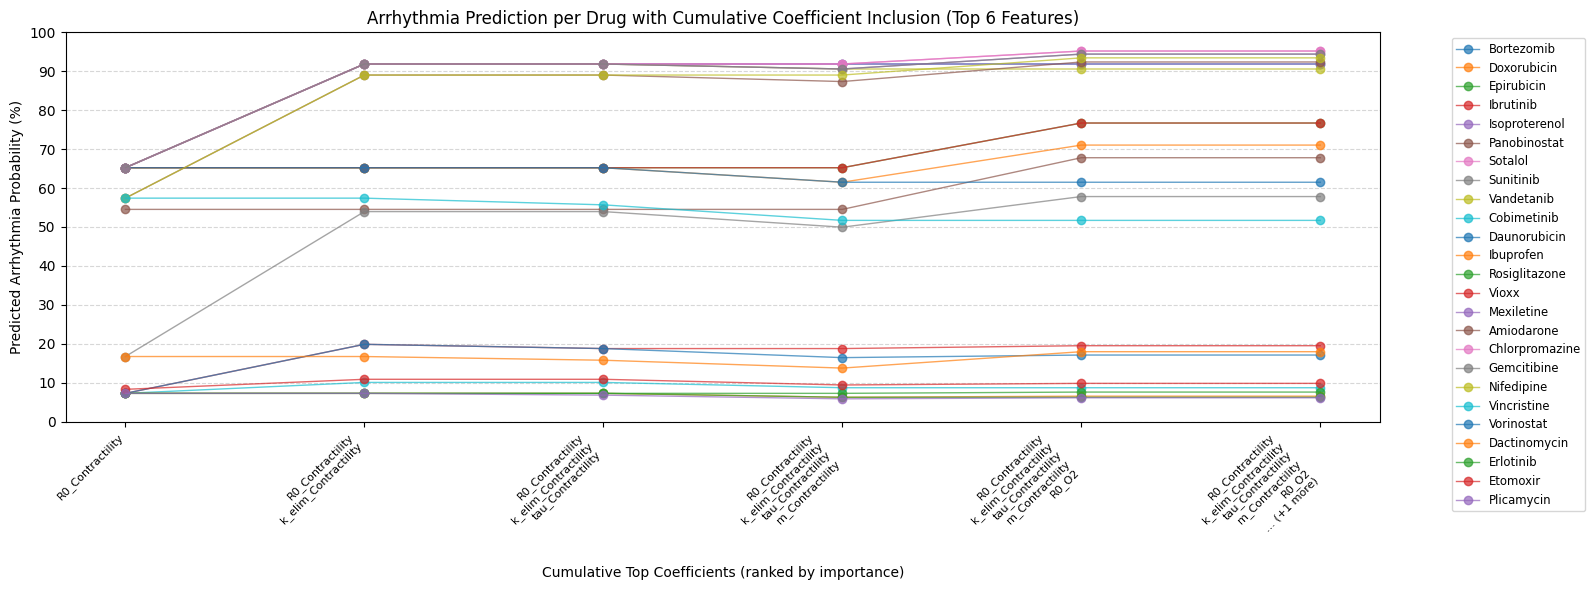

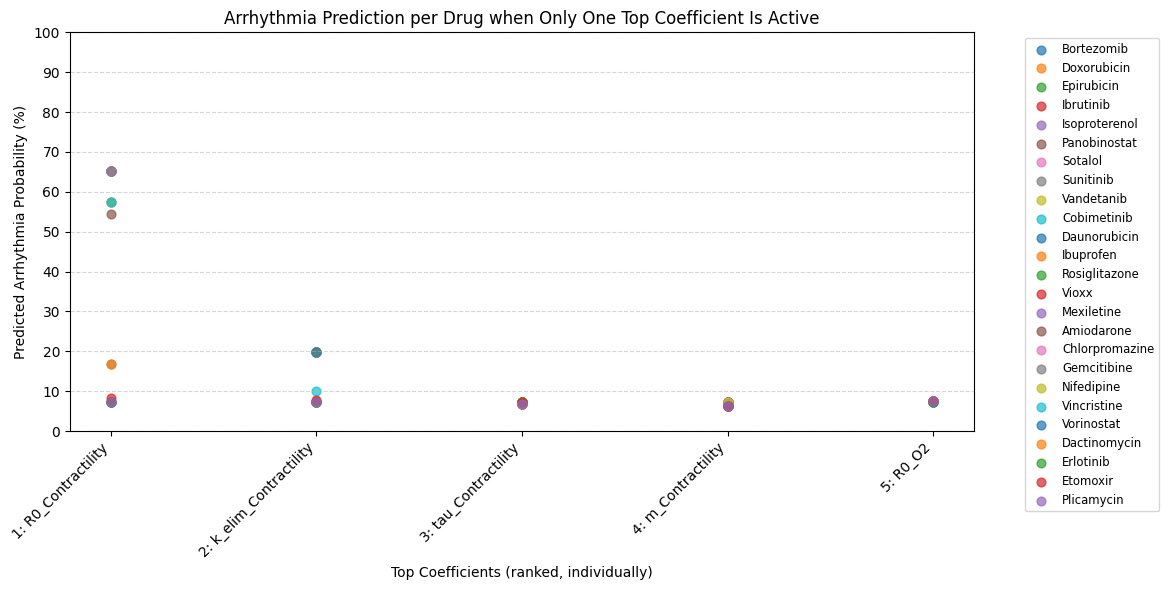


Computing permutation importance for Heart Damage model...
This may take a moment...

Permutation Importance for Heart Damage (Gaussian Kernel):

Permutation Importance for Heart Damage (Gaussian Kernel):


,Feature,Importance
2,kappa_Contractility,0.040
4,m_Contractility,0.036
7,R0_O2,0.032
3,n_Contractility,0.028
11,m_O2,0.028
13,k_elim_O2,0.028
10,n_O2,0.020
12,tau_O2,0.020
5,tau_Contractility,0.020
8,Emax_O2,0.020


In [15]:
# ------- Cumulative "additive" plot (each rank includes all previous top features) -------
top_features = arrhythmia_importances.head(5)['Feature'].tolist()
drug_preds = []
for drug in df_raw['Drug']:
    drug_idx = df_raw.index[df_raw['Drug'] == drug][0]
    for rank in range(1, 7):  # Changed from len(features_df.columns) + 1 to 7
        single_vector = pd.DataFrame(0, index=[0], columns=features_df.columns)
        for past_feature in top_features[:rank]:
            single_vector[past_feature] = features_df.loc[drug_idx, past_feature]
        prob = model_arrhythmia.predict_proba(single_vector)[:, 1][0]
        drug_preds.append({
            'Drug': drug,
            'Rank': rank,
            'Feature(s)': tuple(top_features[:rank]) if rank <= len(top_features) else tuple(top_features),
            'Arrhythmia (%)': prob * 100
        })

plot_df_cumulative = pd.DataFrame(drug_preds)

# Prepare stacked (vertical) feature label for xticklabels - show top 5 explicitly, then "..." for rank 6
def stacked_label(rank):
    if rank <= 5:
        return "\n".join(top_features[:rank])
    else:
        return "\n".join(top_features[:5]) + f"\n... (+{rank-5} more)"

xtick_labels = [stacked_label(i) for i in range(1, 7)]  # Changed from len(features_df.columns) + 1 to 7

plt.figure(figsize=(14, 6))
for drug in plot_df_cumulative['Drug'].unique():
    subset = plot_df_cumulative[plot_df_cumulative['Drug'] == drug]
    plt.plot(
        subset['Rank'], subset['Arrhythmia (%)'],
        marker='o', label=drug, alpha=0.7, linewidth=1
    )

plt.xticks(range(1, 7), xtick_labels, rotation=45, ha='right', fontsize=8)  # Changed from len(features_df.columns) + 1 to 7
plt.yticks(np.linspace(0, 100, 11))
plt.xlabel('Cumulative Top Coefficients (ranked by importance)')
plt.ylabel('Predicted Arrhythmia Probability (%)')
plt.title('Arrhythmia Prediction per Drug with Cumulative Coefficient Inclusion (Top 6 Features)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small')
plt.show()

# ------- Old plot: Each single top coefficient individually (not cumulative) -------
single_coeff_preds = []
for drug in df_raw['Drug']:
    drug_idx = df_raw.index[df_raw['Drug'] == drug][0]
    for rank, feature in enumerate(top_features, start=1):
        single_vector = pd.DataFrame(0, index=[0], columns=features_df.columns)
        single_vector[feature] = features_df.loc[drug_idx, feature]
        prob = model_arrhythmia.predict_proba(single_vector)[:, 1][0]
        single_coeff_preds.append({
            'Drug': drug,
            'Rank': rank,
            'Feature': feature,
            'Arrhythmia (%)': prob * 100
        })

plot_df_single = pd.DataFrame(single_coeff_preds)

plt.figure(figsize=(10, 6))
for drug in plot_df_single['Drug'].unique():
    subset = plot_df_single[plot_df_single['Drug'] == drug]
    plt.scatter(subset['Rank'], subset['Arrhythmia (%)'], label=drug, alpha=0.7, s=40)

plt.xticks(range(1, 6), [f'{i}: {f}' for i, f in enumerate(top_features, start=1)], rotation=45, ha='right')
plt.yticks(np.linspace(0, 100, 11))
plt.xlabel('Top Coefficients (ranked, individually)')
plt.ylabel('Predicted Arrhythmia Probability (%)')
plt.title('Arrhythmia Prediction per Drug when Only One Top Coefficient Is Active')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small')
plt.show()

# ------- Compute Permutation Importance for Heart Damage -------
from sklearn.inspection import permutation_importance

print("\n" + "="*80)
print("Computing permutation importance for Heart Damage model...")
print("This may take a moment...")
print("="*80)

# Compute permutation importance on the full dataset
perm_importance = permutation_importance(
    model_heart_damage, 
    features_df, 
    heart_damage, 
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Create DataFrame with feature importances
heart_damage_importances = pd.DataFrame({
    'Feature': features_df.columns,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

print("\nPermutation Importance for Heart Damage (Gaussian Kernel):")
display(heart_damage_importances)


Using ALL 14 features in NORMAL ORDER (most to least important)
Starting with MOST important: kappa_Contractility
Ending with LEAST important: kappa_O2


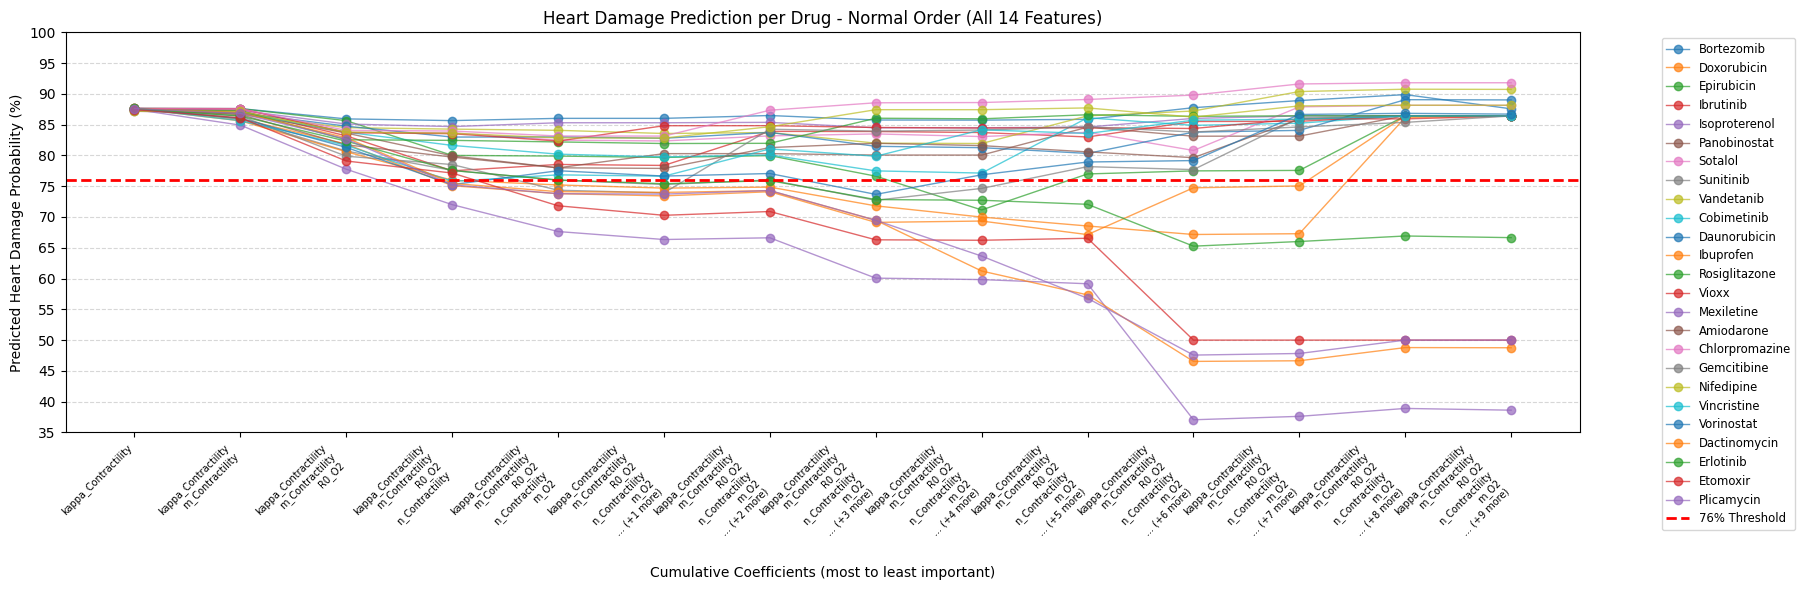

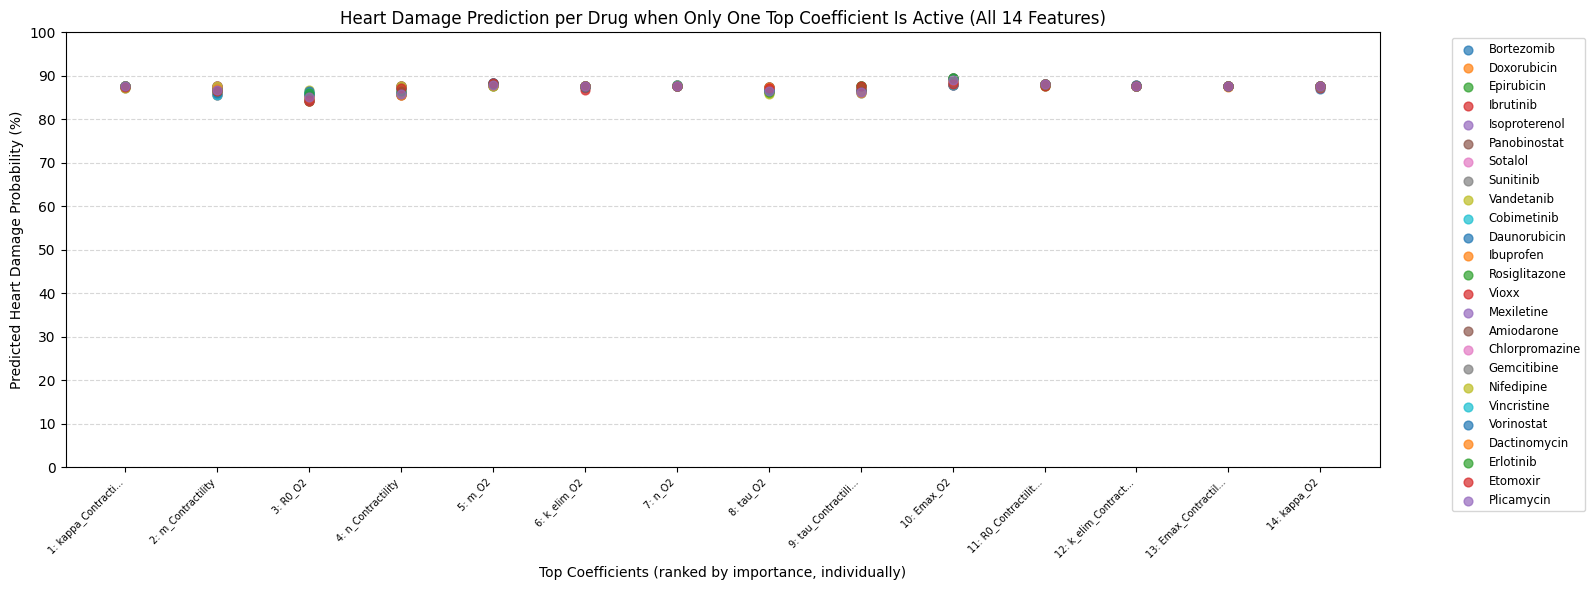

In [19]:
# ------- Cumulative "additive" plot for Heart Damage (ALL FEATURES, NORMAL ORDER) -------
top_features_hd = heart_damage_importances['Feature'].tolist()
num_features_hd = len(top_features_hd)

print(f"\nUsing ALL {num_features_hd} features in NORMAL ORDER (most to least important)")
print(f"Starting with MOST important: {top_features_hd[0]}")
print(f"Ending with LEAST important: {top_features_hd[-1]}")

drug_preds_hd = []
for drug in df_raw['Drug']:
    drug_idx = df_raw.index[df_raw['Drug'] == drug][0]
    for rank in range(1, num_features_hd + 1):
        single_vector = pd.DataFrame(0, index=[0], columns=features_df.columns)
        for past_feature in top_features_hd[:rank]:
            single_vector[past_feature] = features_df.loc[drug_idx, past_feature]
        prob = model_heart_damage.predict_proba(single_vector)[:, 1][0]
        drug_preds_hd.append({
            'Drug': drug,
            'Rank': rank,
            'Feature(s)': tuple(top_features_hd[:rank]),
            'Heart Damage (%)': prob * 100
        })

plot_df_cumulative_hd = pd.DataFrame(drug_preds_hd)

def stacked_label_hd(rank):
    if rank <= 5:
        return "\n".join(top_features_hd[:rank])
    else:
        return "\n".join(top_features_hd[:5]) + f"\n... (+{rank-5} more)"

xtick_labels_hd = [stacked_label_hd(i) for i in range(1, num_features_hd + 1)]

plt.figure(figsize=(16, 6))
for drug in plot_df_cumulative_hd['Drug'].unique():
    subset = plot_df_cumulative_hd[plot_df_cumulative_hd['Drug'] == drug]
    plt.plot(
        subset['Rank'], subset['Heart Damage (%)'],
        marker='o', label=drug, alpha=0.7, linewidth=1
    )

plt.axhline(y=76, color='red', linestyle='--', linewidth=2, label='76% Threshold')
plt.xticks(range(1, num_features_hd + 1), xtick_labels_hd, rotation=45, ha='right', fontsize=7)
plt.yticks(np.linspace(35, 100, 14))
plt.ylim(35, 100)
plt.xlabel('Cumulative Coefficients (most to least important)')
plt.ylabel('Predicted Heart Damage Probability (%)')
plt.title(f'Heart Damage Prediction per Drug - Normal Order (All {num_features_hd} Features)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small')
plt.show()

# ------- Single-feature plot (not cumulative, for reference) -------
single_coeff_preds_hd = []
for drug in df_raw['Drug']:
    drug_idx = df_raw.index[df_raw['Drug'] == drug][0]
    for rank, feature in enumerate(top_features_hd, start=1):
        single_vector = pd.DataFrame(0, index=[0], columns=features_df.columns)
        single_vector[feature] = features_df.loc[drug_idx, feature]
        prob = model_heart_damage.predict_proba(single_vector)[:, 1][0]
        single_coeff_preds_hd.append({
            'Drug': drug,
            'Rank': rank,
            'Feature': feature,
            'Heart Damage (%)': prob * 100
        })

plot_df_single_hd = pd.DataFrame(single_coeff_preds_hd)
single_tick_labels = [f'{i}: {f[:15]}...' if len(f) > 15 else f'{i}: {f}' for i, f in enumerate(top_features_hd, start=1)]

plt.figure(figsize=(14, 6))
for drug in plot_df_single_hd['Drug'].unique():
    subset = plot_df_single_hd[plot_df_single_hd['Drug'] == drug]
    plt.scatter(subset['Rank'], subset['Heart Damage (%)'], label=drug, alpha=0.7, s=40)

plt.xticks(range(1, num_features_hd + 1), single_tick_labels, rotation=45, ha='right', fontsize=7)
plt.yticks(np.linspace(0, 100, 11))
plt.xlabel('Top Coefficients (ranked by importance, individually)')
plt.ylabel('Predicted Heart Damage Probability (%)')
plt.title(f'Heart Damage Prediction per Drug when Only One Top Coefficient Is Active (All {num_features_hd} Features)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small')
plt.show()


## SHAP Feature Importance - Arrhythmia Model
SHAP (SHapley Additive exPlanations) provides a unified measure of feature importance by assigning each feature an importance value for a particular prediction.

Arrhythmia — Top 10 features: R0_Contractility, k_elim_Contractility, kappa_O2, Emax_O2, kappa_Contractility, Emax_Contractility, R0_O2, tau_Contractility, m_O2, m_Contractility


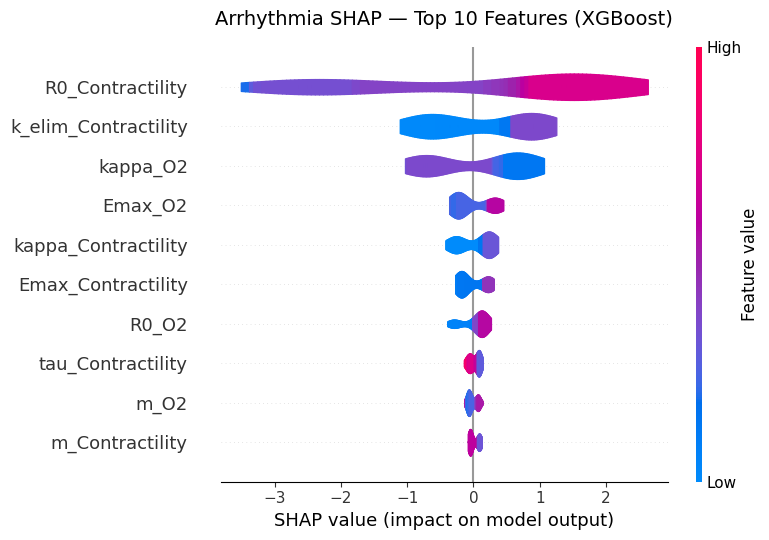

Computing Kernel SHAP for Heart Damage (all features)...


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]



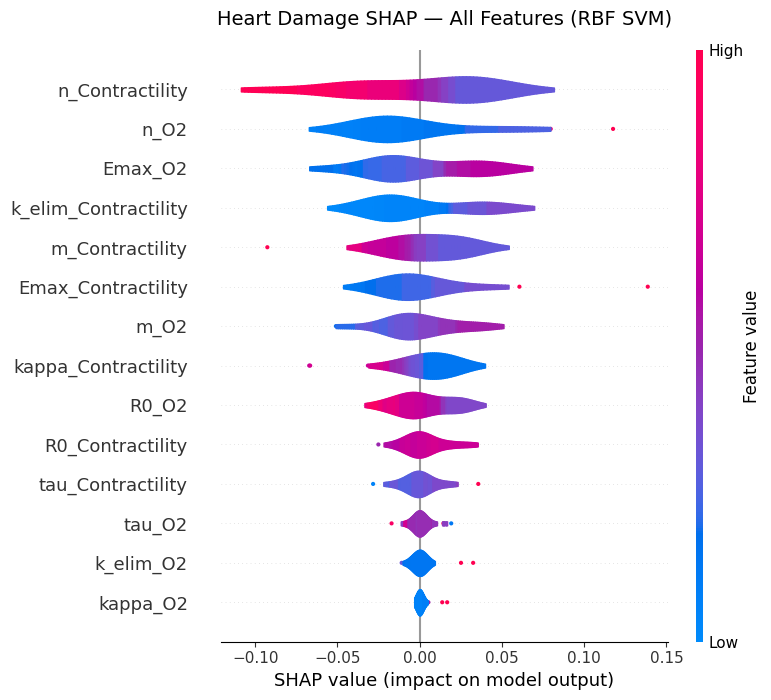

In [30]:
# SHAP Summary — Arrhythmia (XGBoost, Top 10) and Heart Damage (RBF SVM, All Features)
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# ===========================
# Arrhythmia: XGBoost (Top 10)
# ===========================
# Extract model and scaler from pipeline
xgb_model = model_arrhythmia.named_steps['xgb']
scaler = model_arrhythmia.named_steps['scaler']

# Scale features
X_scaled = scaler.transform(features_df)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_df.columns, index=features_df.index)

# SHAP TreeExplainer
explainer_arr = shap.TreeExplainer(xgb_model)
shap_values_arr = explainer_arr.shap_values(X_scaled)

# Top 10 features by mean |SHAP|
mean_abs_shap_arr = np.abs(shap_values_arr).mean(axis=0)
top_10_idx_arr = np.argsort(mean_abs_shap_arr)[-10:][::-1]
top_10_features_arr = features_df.columns[top_10_idx_arr].tolist()
print("Arrhythmia — Top 10 features:", ", ".join(top_10_features_arr))

# Plot Arrhythmia SHAP Top 10 (violin)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_arr[:, top_10_idx_arr], X_scaled_df.iloc[:, top_10_idx_arr],
                  plot_type="violin", show=False)
plt.title('Arrhythmia SHAP — Top 10 Features (XGBoost)', fontsize=14, pad=16)
plt.tight_layout()
plt.show()

# =========================================
# Heart Damage: RBF SVM (All features, KernelSHAP)
# =========================================
feature_names_hd = features_df.columns.tolist()

def predict_hd(X):
    X_df = pd.DataFrame(X, columns=feature_names_hd)
    return model_heart_damage.predict_proba(X_df)[:, 1]

# Use compact background for Kernel SHAP
try:
    background = shap.kmeans(features_df, k=min(10, len(features_df)))
except Exception:
    background = features_df.sample(min(10, len(features_df)), random_state=42).values

print("Computing Kernel SHAP for Heart Damage (all features)...")
explainer_hd = shap.KernelExplainer(predict_hd, background)
shap_values_hd = explainer_hd.shap_values(features_df.values, nsamples='auto')

# Plot Heart Damage SHAP (violin, all features)
plt.figure(figsize=(12, 9))
shap.summary_plot(shap_values_hd, features_df, plot_type='violin', show=False)
plt.title('Heart Damage SHAP — All Features (RBF SVM)', fontsize=14, pad=18)
plt.tight_layout()
plt.show()

XGBoost Model Information
Number of trees: 150
Max depth: 4
Actual trees in booster: 150



Tree 0 - Overall Structure (All Drugs Distribution)


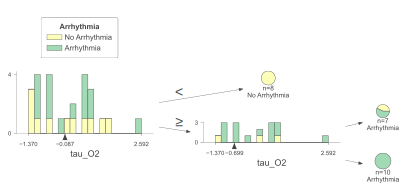

In [33]:
# Visualize XGBoost trees using dtreeviz (new API)
# Reference: https://stackoverflow.com/questions/75576403
import dtreeviz
import numpy as np

# Extract the XGBoost model and scaler from the pipeline
xgb_model = model_arrhythmia.named_steps['xgb']
scaler = model_arrhythmia.named_steps['scaler']

# Scale all features for visualization
X_scaled = scaler.transform(features_df)
y_labels = arrhythmia if isinstance(arrhythmia, np.ndarray) else arrhythmia.values

# Print model info
print("="*80)
print("XGBoost Model Information")
print("="*80)
print(f"Number of trees: {xgb_model.n_estimators}")
print(f"Max depth: {xgb_model.max_depth}")
print(f"Actual trees in booster: {len(xgb_model.get_booster().get_dump())}")

# Create model visualization object using new API (model= keyword required)
tree_idx = 0
viz_model = dtreeviz.model(
    model=xgb_model,
    tree_index=tree_idx,
    X_train=X_scaled,
    y_train=y_labels,
    feature_names=features_df.columns.tolist(),
    class_names=['No Arrhythmia', 'Arrhythmia'],
    target_name='Arrhythmia'
)

# ============================================================
# GRAPH 1: Overall tree structure with all drug distributions
# ============================================================
print(f"\n{'='*80}")
print(f"Tree {tree_idx} - Overall Structure (All Drugs Distribution)")
print(f"{'='*80}")

viz_all = viz_model.view(orientation='LR')
display(viz_all)



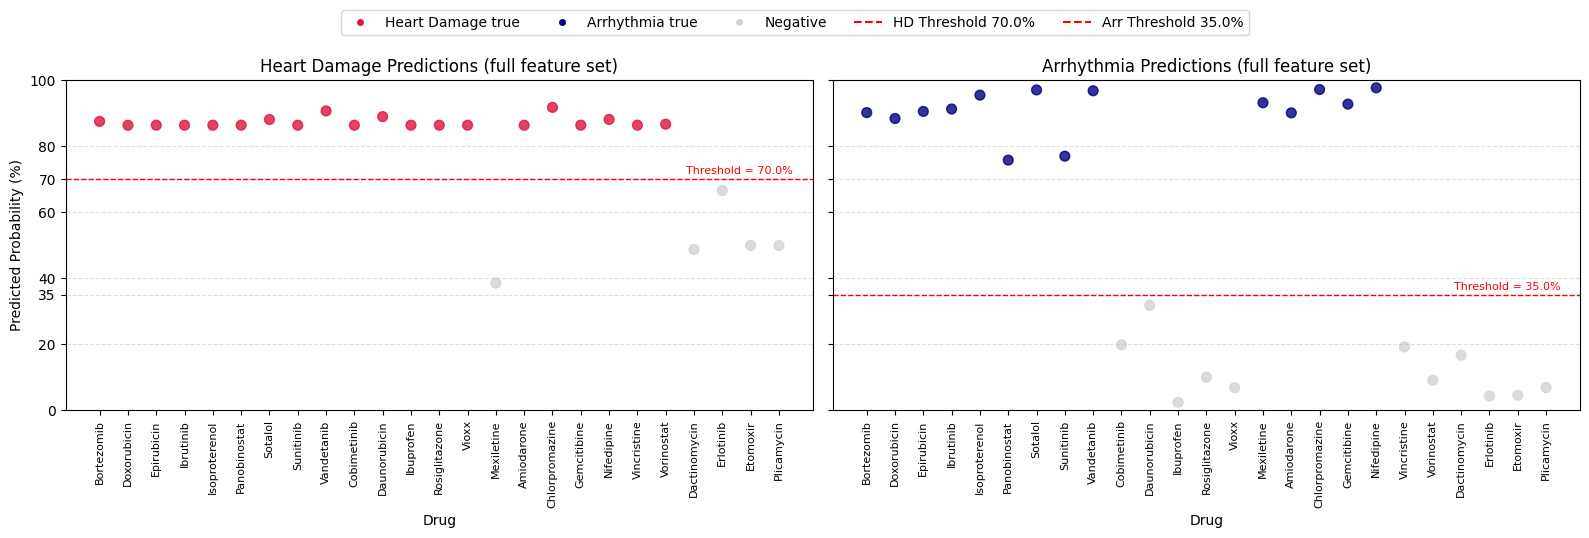

In [20]:
# Dynamic thresholds: set slightly above the highest negative prediction per target
margin_pp = 2.0  # wiggle room in percentage points

full_preds_hd = model_heart_damage.predict_proba(features_df)[:, 1] * 100
full_preds_arr = model_arrhythmia.predict_proba(features_df)[:, 1] * 100
drugs = df_raw['Drug']
positions = np.arange(len(drugs))

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

thresholds = {}

for ax, preds, label, color in zip(
    axes,
    [full_preds_hd, full_preds_arr],
    ['Heart Damage', 'Arrhythmia'],
    ['crimson', 'navy']
):
    status = (df_raw['heart_damage'] if label == 'Heart Damage' else df_raw['Arrhythmia']).astype(bool)
    point_colors = status.map({True: color, False: 'lightgray'})
    ax.scatter(positions, preds, c=point_colors, alpha=0.8, s=50)
    ax.set_xticks(positions)
    ax.set_xticklabels(drugs, rotation=90, fontsize=8)
    ax.set_title(f'{label} Predictions (full feature set)')
    ax.set_xlabel('Drug')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    if ax is axes[0]:
        ax.set_ylabel('Predicted Probability (%)')
    ax.set_ylim(0, 100)

    # Compute threshold: highest negative prediction + small margin
    neg_mask = ~status.values
    if neg_mask.any():
        thr = float(np.max(preds[neg_mask])) + margin_pp
    else:
        thr = float(np.percentile(preds, 50)) + margin_pp  # fallback if no negatives
    thr = float(np.clip(thr, 0, 100))
    # Round UP to nearest 5
    thr = float(5 * np.ceil(thr / 5.0))
    thresholds[label] = thr

    # Add red horizontal threshold line and ensure its tick is shown
    ax.axhline(thr, color='red', linestyle='--', linewidth=1)
    yticks = ax.get_yticks()
    if thr not in yticks:
        ax.set_yticks(sorted(np.append(yticks, thr)))
    ax.text(len(drugs) - 0.5, thr + 1, f'Threshold = {thr:.1f}%', color='red',
            fontsize=8, va='bottom', ha='right')

# Ensure shared y-axis shows both rounded thresholds
ticks0 = axes[0].get_yticks()
ticks1 = axes[1].get_yticks()
shared_ticks = sorted(np.unique(np.concatenate([ticks0, ticks1])))
axes[0].set_yticks(shared_ticks)
axes[1].set_yticks(shared_ticks)

fig.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='crimson', label='Heart Damage true'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='navy', label='Arrhythmia true'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', label='Negative'),
    plt.Line2D([0], [0], color='red', linestyle='--', label=f'HD Threshold {thresholds.get("Heart Damage", np.nan):.1f}%'),
    plt.Line2D([0], [0], color='red', linestyle='--', label=f'Arr Threshold {thresholds.get("Arrhythmia", np.nan):.1f}%')
], loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.08))

plt.tight_layout()
plt.show()

In [18]:
# Cell 15: Save All Important Features to CSV
# Depends on: Cell 17 (Arrhythmia model), Cell 20 (Heart Damage model), Cell 22 (Concern model), Cell 27 (Feature Importance Summary)

print("="*80)
print("SAVING ALL IMPORTANT FEATURES TO CSV")
print("="*80)

from sklearn.inspection import permutation_importance

# Collect feature importances from all models
all_features_list = []

# 1. Arrhythmia (XGBoost) - has feature importances
print("\n1. Collecting Arrhythmia (XGBoost) feature importances...")
arrhythmia_importances = results_arrhythmia['feature_importances'].copy()
arrhythmia_importances['Model'] = 'Arrhythmia'
all_features_list.append(arrhythmia_importances[['Model', 'Feature', 'Importance']])

# 2. Heart Damage (Gaussian Kernel SVM) - calculate permutation importance
print("2. Calculating Heart Damage (Gaussian Kernel) permutation importance...")
perm_heart_damage = permutation_importance(
    model_heart_damage,
    features_df,
    heart_damage,
    scoring='roc_auc',
    n_repeats=200,
    random_state=42,
    n_jobs=-1
)
heart_damage_importances = pd.DataFrame({
    'Feature': features_df.columns,
    'Importance': perm_heart_damage.importances_mean
}).sort_values('Importance', ascending=False)
heart_damage_importances['Model'] = 'Heart Damage'
all_features_list.append(heart_damage_importances[['Model', 'Feature', 'Importance']])

# 3. Concern (Random Forest) - has feature importances
print("3. Collecting Concern (Random Forest) feature importances...")
concern_importances = results_concern_rf['feature_importances'].copy()
concern_importances['Model'] = 'Concern'
all_features_list.append(concern_importances[['Model', 'Feature', 'Importance']])

# Combine all features into a single DataFrame
all_features_df = pd.concat(all_features_list, ignore_index=True)

# Reorder columns: Model, Feature, Importance
all_features_df = all_features_df[['Model', 'Feature', 'Importance']]

# Save to CSV
output_dir = PROJECT_ROOT / 'Output' / 'Model_Properties'
output_dir.mkdir(parents=True, exist_ok=True)

csv_path = output_dir / 'all_models_important_features.csv'
all_features_df.to_csv(csv_path, index=False)

print(f"\n✓ Saved all important features to: {csv_path}")
print(f"\nTotal features saved: {len(all_features_df)}")
print(f"  - Arrhythmia: {len(arrhythmia_importances)} features")
print(f"  - Heart Damage: {len(heart_damage_importances)} features")
print(f"  - Concern: {len(concern_importances)} features")

print(f"\nFirst few rows of saved CSV:")
display(all_features_df.head(10))


SAVING ALL IMPORTANT FEATURES TO CSV

1. Collecting Arrhythmia (XGBoost) feature importances...
2. Calculating Heart Damage (Gaussian Kernel) permutation importance...
3. Collecting Concern (Random Forest) feature importances...

✓ Saved all important features to: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Model_Properties\all_models_important_features.csv

Total features saved: 42
  - Arrhythmia: 14 features
  - Heart Damage: 14 features
  - Concern: 14 features

First few rows of saved CSV:
3. Collecting Concern (Random Forest) feature importances...

✓ Saved all important features to: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Model_Properties\all_models_important_features.csv

Total features saved: 42
  - Arrhythmia: 14 features
  - Heart Damage: 14 features
  - Concern: 14 features

First few rows of saved CSV:


,Model,Feature,Importance
0,Arrhythmia,R0_Contractility,0.269799
1,Arrhythmia,k_elim_Contractility,0.104979
2,Arrhythmia,tau_Contractility,0.103587
3,Arrhythmia,m_Contractility,0.099338
4,Arrhythmia,R0_O2,0.094837
5,Arrhythmia,n_O2,0.074466
6,Arrhythmia,kappa_Contractility,0.050019
7,Arrhythmia,kappa_O2,0.047848
8,Arrhythmia,Emax_O2,0.046190
9,Arrhythmia,m_O2,0.041327


## Step 14: Save Models (Optional)

Save the trained models and feature importance DataFrames for later use.


In [ ]:
# Cell 15: Save Models (Optional)
if not XGBOOST_AVAILABLE:
    print("ERROR: XGBoost is not installed. Cannot save models.")
else:
    import joblib

    # Create output directory
    output_dir = PROJECT_ROOT / 'Output' / 'Model_Properties'
    output_dir.mkdir(parents=True, exist_ok=True)

    print("="*80)
    print("SAVING MODELS AND RESULTS")
    print("="*80)

    # Save models
    model_paths = {}
    # Save Arrhythmia and Heart_Damage models
    for target_name, model in [('Arrhythmia', model_arrhythmia), ('Heart_Damage', model_heart_damage)]:
        model_path = output_dir / f'xgb_pkpd_elimination_{target_name}.joblib'
        joblib.dump(model, model_path)
        model_paths[target_name] = model_path
        print(f"  Saved model: {model_path}")
    # Save Concern model (Random Forest)
    if 'model' in results_concern_rf:
        concern_model_path = output_dir / 'random_forest_pkpd_elimination_Concern.joblib'
        joblib.dump(results_concern_rf['model'], concern_model_path)
        model_paths['Concern'] = concern_model_path
        print(f"  Saved model: {concern_model_path}")
    else:
        print("WARNING: Concern model not available in results_concern_rf, not saving.")

    # Save feature importances/coefficients (different models have different structures)
    importance_paths = {}

    # Arrhythmia: XGBoost has feature_importances
    if 'feature_importances' in results_arrhythmia and results_arrhythmia['feature_importances'] is not None:
        importance_path = output_dir / f'xgb_pkpd_elimination_Arrhythmia_feature_importances.csv'
        results_arrhythmia['feature_importances'].to_csv(importance_path, index=False)
        importance_paths['Arrhythmia'] = importance_path
        print(f"  Saved feature importances: {importance_path}")

    # Heart Damage: Gaussian Kernel (SVM) doesn't have feature importances
    if 'feature_importances' in results_heart_damage and results_heart_damage['feature_importances'] is not None:
        importance_path = output_dir / f'xgb_pkpd_elimination_Heart_Damage_feature_importances.csv'
        results_heart_damage['feature_importances'].to_csv(importance_path, index=False)
        importance_paths['Heart_Damage'] = importance_path
        print(f"  Saved feature importances: {importance_path}")
    else:
        print(f"  Heart Damage (Gaussian Kernel): No feature importances available (SVM with RBF kernel)")

    # Concern: Random Forest feature importances
    if 'feature_importances' in results_concern_rf and results_concern_rf['feature_importances'] is not None:
        importance_path = output_dir / f'random_forest_pkpd_elimination_Concern_feature_importances.csv'
        results_concern_rf['feature_importances'].to_csv(importance_path, index=False)
        importance_paths['Concern'] = importance_path
        print(f"  Saved feature importances: {importance_path}")
    else:
        print(f"  Concern: No feature importances available.")

    # Save performance summary
    summary_path = output_dir / 'xgb_pkpd_elimination_performance_summary.csv'
    comparison_df[['Target', 'Mean CV Accuracy', 'Std CV Accuracy',
                   'Mean CV F1-Score', 'Std CV F1-Score', 'Number of Features']].to_csv(summary_path, index=False)
    print(f"  Saved performance summary: {summary_path}")

    print(f"\n✓ All models and results saved to: {output_dir}")
    print("\nSaved files:")
    for target_name in ['Arrhythmia', 'Heart_Damage', 'Concern']:
        if target_name in model_paths:
            print(f"  - {model_paths[target_name].name}")
        else:
            print(f"  - No model file saved for {target_name}")
        if target_name in importance_paths:
            print(f"  - {importance_paths[target_name].name}")
        else:
            print(f"  - No feature importance file saved for {target_name}")
    print(f"  - {summary_path.name}")

SAVING MODELS AND RESULTS
  Saved model: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Model_Properties\xgb_pkpd_elimination_Arrhythmia.joblib
  Saved model: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Model_Properties\xgb_pkpd_elimination_Heart_Damage.joblib
  Saved feature importances: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Model_Properties\xgb_pkpd_elimination_Arrhythmia_feature_importances.csv
  Heart Damage (Gaussian Kernel): No feature importances available (SVM with RBF kernel)
  Saved feature importances: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Model_Properties\random_forest_pkpd_elimination_Concern_feature_importances.csv
  Saved performance summary: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RODEO\Output\Model_Properties\xgb_pkpd_elimination_performance_summary.csv

✓ All models and results saved to: c:\Users\NoahB\Documents\HebrewU Bioengineering\Cardiac_RO

## PCA Decision Surface — Heart Damage (RBF SVM)
This view projects features to 2D via PCA, then fits a surrogate RBF SVM in that 2D space to visualize a smooth decision surface. Colors show predicted heart-damage probability; dashed contour marks the 76% threshold.

PCA explained variance: PC1=21.76%, PC2=16.70%


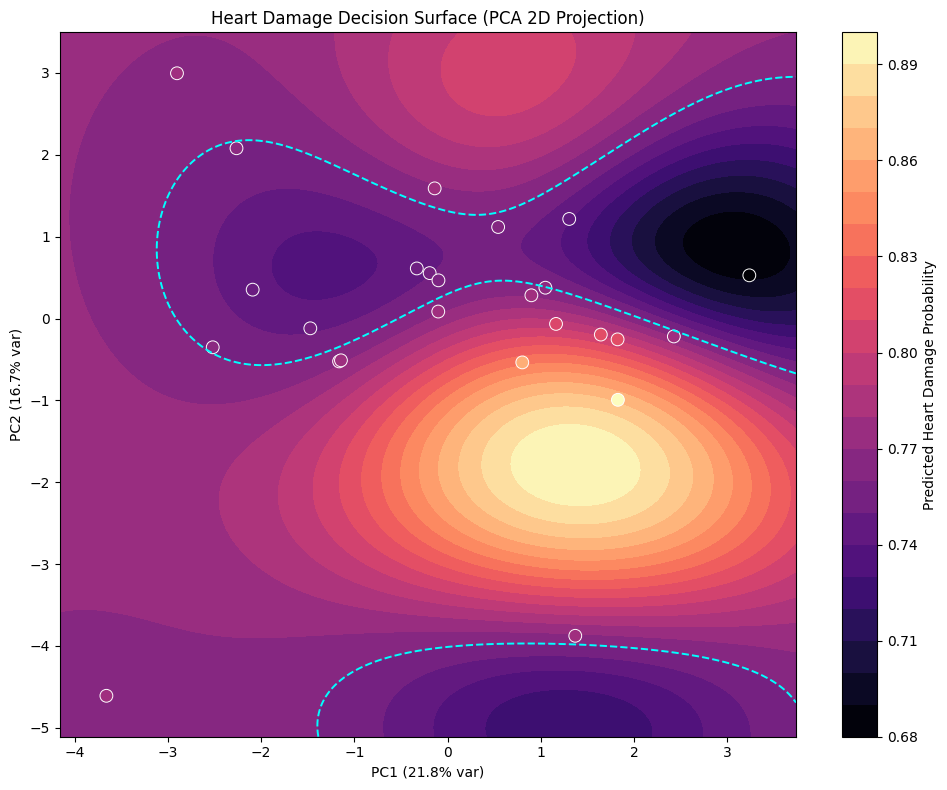

In [26]:
# PCA-based Decision Surface for Heart Damage (surrogate in PCA space)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Prepare input matrix using pipeline scaler if present
try:
    scaler_hd = model_heart_damage.named_steps.get('scaler', None)
except Exception:
    scaler_hd = None

if scaler_hd is not None:
    X_in = scaler_hd.transform(features_df)
else:
    X_in = features_df.values

# Fit PCA to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_in)
expl = pca.explained_variance_ratio_
print(f"PCA explained variance: PC1={expl[0]:.2%}, PC2={expl[1]:.2%}")

# Train a surrogate SVM in PCA space for visualization
svm_pca = SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', random_state=42)
svm_pca.fit(X_pca, heart_damage)

# Build grid in PCA space
pad = 0.5
pc1_min, pc1_max = X_pca[:, 0].min() - pad, X_pca[:, 0].max() + pad
pc2_min, pc2_max = X_pca[:, 1].min() - pad, X_pca[:, 1].max() + pad
res = 300
xx, yy = np.meshgrid(np.linspace(pc1_min, pc1_max, res), np.linspace(pc2_min, pc2_max, res))
Z = svm_pca.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

# Plot decision surface
plt.figure(figsize=(10, 8))
cont = plt.contourf(xx, yy, Z, levels=25, cmap='magma')
cbar = plt.colorbar(cont)
cbar.set_label('Predicted Heart Damage Probability')

# Overlay drugs colored by surrogate probability
probs_pca = svm_pca.predict_proba(X_pca)[:, 1]
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=probs_pca, cmap='magma', edgecolor='white', s=85, linewidth=0.7)

# 76% threshold contour (if exists in range)
try:
    plt.contour(xx, yy, Z, levels=[0.76], colors='cyan', linestyles='--', linewidths=1.4)
except Exception as e:
    print("Could not draw 76% contour:", e)

plt.title('Heart Damage Decision Surface (PCA 2D Projection)')
plt.xlabel(f"PC1 ({expl[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({expl[1]*100:.1f}% var)")
plt.tight_layout()
plt.show()

## Decision Boundary (Feature Slice) — Heart Damage
This view varies two real features on a grid (others fixed at median) and plots the model's predicted probability as a smooth surface. Points show drugs colored by predicted risk; dashed red marks the 76% threshold.

Using features for boundary: kappa_Contractility, m_Contractility


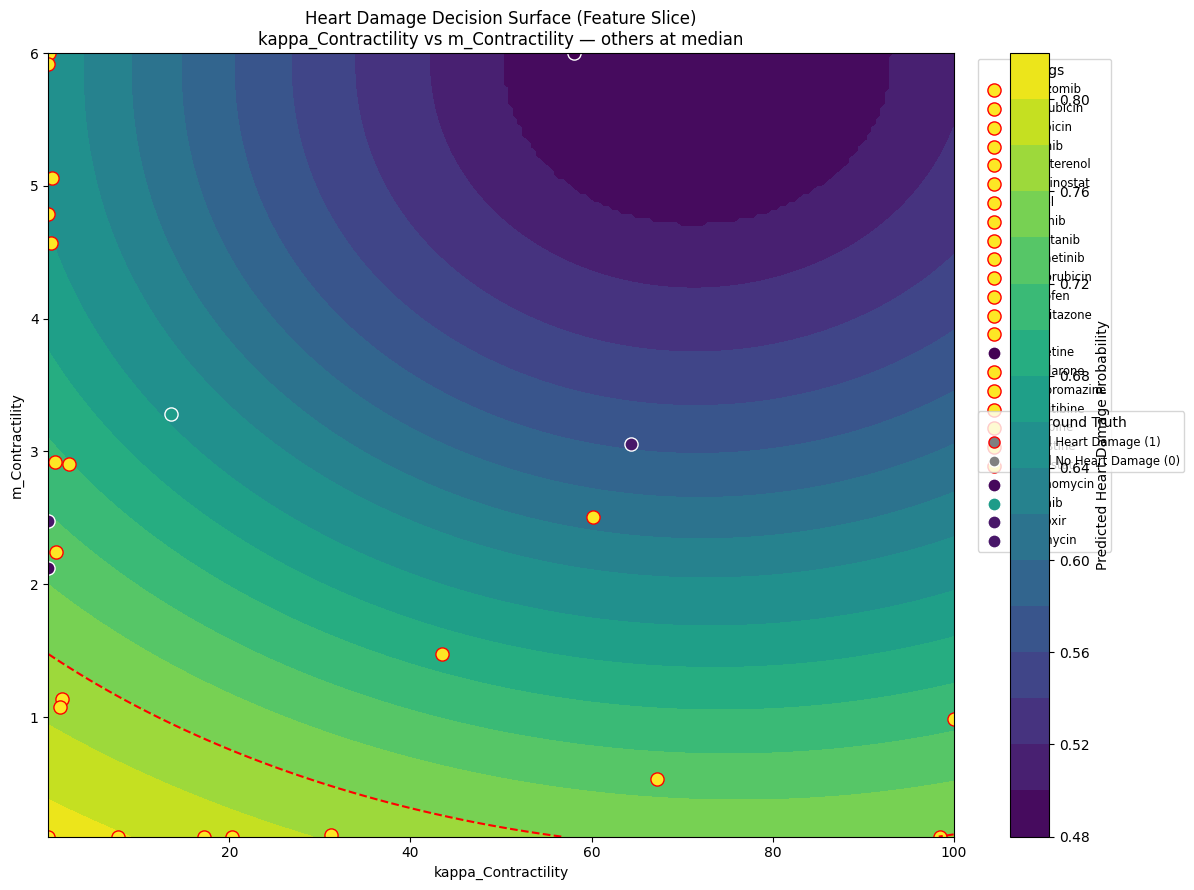

In [ ]:
# Decision Boundary Map (Feature Slice) for Heart Damage — top 2 features
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Require permutation importance to have been computed earlier
if 'heart_damage_importances' not in globals():
    raise RuntimeError("heart_damage_importances not found. Run the Heart Damage importance cell first.")

# Pick features: top 2 by permutation importance (override manually if desired)
f1, f2 = heart_damage_importances['Feature'].iloc[:2].tolist()
print(f"Using features for boundary: {f1}, {f2}")

# Define grid ranges from observed data
x_min, x_max = features_df[f1].min(), features_df[f1].max()
y_min, y_max = features_df[f2].min(), features_df[f2].max()

# Grid resolution
grid_points = 200
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, grid_points),
    np.linspace(y_min, y_max, grid_points)
)

# Baseline for other features: median values
baseline = features_df.median()

# Build grid DataFrame efficiently: tile baseline, then overwrite f1/f2 columns
grid_df = pd.DataFrame(
    np.tile(baseline.values, (grid_points * grid_points, 1)),
    columns=features_df.columns
)

grid_df[f1] = xx.ravel()
grid_df[f2] = yy.ravel()

# Predict probabilities from the pipeline (handles scaling internally)
probs = model_heart_damage.predict_proba(grid_df)[:, 1]
Z = probs.reshape(grid_points, grid_points)

# Plot decision surface
plt.figure(figsize=(12, 9))
cont = plt.contourf(xx, yy, Z, levels=20, cmap='viridis')
# slimmer colorbar
cbar = plt.colorbar(cont, fraction=0.03, pad=0.02)
cbar.set_label('Predicted Heart Damage Probability')

# Overlay actual drug points colored by model probabilities
actual_probs = model_heart_damage.predict_proba(features_df)[:, 1]
edgecolors = ['red' if int(a) == 1 else 'white' for a in heart_damage]

# Plot each drug and annotate with its name (avoid huge overlapping legend)
rng_x = (x_max - x_min) or 1.0
rng_y = (y_max - y_min) or 1.0
offset_x = 0.012 * rng_x
offset_y = 0.012 * rng_y

for idx, (x, y, p, drug, edge) in enumerate(zip(features_df[f1], features_df[f2], actual_probs, df_raw['Drug'], edgecolors)):
    plt.scatter(x, y, c=[p], cmap=cont.cmap, norm=cont.norm,
                edgecolor=edge, s=70, linewidth=0.9)
    # Stagger labels to reduce collisions
    dx = offset_x if (idx % 2 == 0) else -offset_x
    dy = offset_y if (idx % 3 == 0) else -offset_y
    plt.text(x + dx, y + dy, str(drug), fontsize=7, color='black', alpha=0.9,
             ha='left' if dx > 0 else 'right', va='center')

# Draw 76% probability contour if within range
try:
    plt.contour(xx, yy, Z, levels=[0.76], colors='red', linestyles='--', linewidths=1.3)
except Exception as e:
    print('Could not draw 76% contour:', e)

plt.xlabel(f1)
plt.ylabel(f2)
plt.title(f'Heart Damage Decision Surface (Feature Slice)\n{f1} vs {f2} — others at median')
plt.tight_layout()

# Legend only for ground-truth border meaning
custom_handles = [
    Line2D([0], [0], marker='o', color='w', label='Actual Heart Damage (1)',
           markerfacecolor='gray', markeredgecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Actual No Heart Damage (0)',
           markerfacecolor='gray', markeredgecolor='white', markersize=8)
]
plt.legend(handles=custom_handles, title='Ground Truth', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')

plt.show()

## SHAP Feature Importance — Heart Damage (RBF SVM)
Because the Heart Damage model uses a non-linear RBF SVM, we use SHAP KernelExplainer to estimate per-feature contributions. The plots below show the impact of all features across drugs (violin) and the overall mean absolute importance (bar).

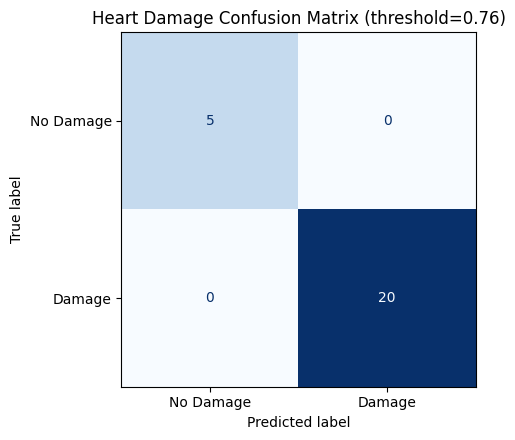


Classification report (threshold = 0.76):
              precision    recall  f1-score   support

   No Damage       1.00      1.00      1.00         5
      Damage       1.00      1.00      1.00        20

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



In [31]:
# Confusion Matrix — Heart Damage (threshold = 0.76)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Use model probabilities and apply clinical threshold
threshold = 0.76
y_true = heart_damage.astype(int)
y_prob = model_heart_damage.predict_proba(features_df)[:, 1]
y_pred = (y_prob >= threshold).astype(int)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Damage', 'Damage'])

fig, ax = plt.subplots(figsize=(5.5, 4.5))
disp.plot(ax=ax, values_format='d', cmap='Blues', colorbar=False)
ax.set_title(f'Heart Damage Confusion Matrix (threshold={threshold:.2f})')
plt.tight_layout()
plt.show()

print('\nClassification report (threshold = %.2f):' % threshold)
print(classification_report(y_true, y_pred, target_names=['No Damage', 'Damage']))